## Import libraries

In [52]:
# Import libraries
import os
import zipfile
import pandas as pd
import geopandas as gpd
import laspy
import subprocess
import json
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## Access relevant data from the S3

In [5]:
# -*- coding: utf-8 -*-
"""
Collect CSV data from BILs and look at why there are -99999 values

@author: mburnett
"""
# Input CSV is the bil.csv file
input_csv = r"C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\1396_ATCO2023_12N_256_AGT_04Jun24.bil.csv"
# Location where you will paste the S3 files you extracted onto your AWS :
SiVi_errors_directory = r"C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\setup\12N_errors"
aws_bin_with_directory = r"atcoelectric.cm2023/Production/UTM12N_CSRS/ImageryDescriptorsML/"
aws_bin_with_LASdirectory = r"atcoelectric.cm2023/Production/UTM12N_CSRS/clean_las_256/clean/"
aws_output_directory = "D://ATCO2023//SiVi//AGT_12N//"
running_AGT = True # False if you're running production polys

output_csv = input_csv.replace(".csv","_forAWSbatch.csv")
#productionPolys = r"C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\2023_production_shapefiles\05b_11N_256_production_polys_UTM11N_CSRS.shp"

# Function to filter rows with -99999 values
def filter_rows_with_value(input_csv, output_csv, aws_dir, aws_LASdir, aws_out_dir, running_AGT, value_to_filter=-99999):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_csv)
    
    # Filter rows that have the value_to_filter in any column
    filtered_df = df[(df == value_to_filter).any(axis=1)]
    
    if running_AGT == True:
        input_shp = input_csv.replace(".bil.csv","InitialShapes.shp") # Access real SHP name
        shp = gpd.read_file(input_shp)
        filtered_shp = shp[shp.index.isin(filtered_df.index)] # Keep relevant shapes and get production poly
        
        new_rows = []
        for index,row in filtered_df.iterrows():
            columns_OI = row[row == value_to_filter].index.tolist() # Keep only columns of interest
            if index < len(shp):
                stand_id = shp.iloc[index]['STANDID'] # Access relevant standID
                if "SiViTREESPEC" in columns_OI: # Get the SiVi CSVs and LAZ if it's a SiVi descriptor error
                    for column in columns_OI:
                        new_rows.append(f"aws s3 cp s3://{aws_dir}SiViDescCSV/SiViDescCSV_{stand_id}.zip {aws_out_dir}")
                        new_rows.append(f"aws s3 cp s3://{aws_LASdir}{stand_id}.laz {aws_out_dir}")
                else: # For all other descriptor errors
                    for column in columns_OI:
                        new_rows.append(f"aws s3 cp s3://{aws_dir}{column}/{column}_{stand_id}.tif {aws_out_dir}")
    
    else:
        new_rows = []
        unique_ids = []
        for index,row in filtered_df.iterrows():
            columns_OI = row[row == value_to_filter].index.tolist() # Keep only columns of interest
            if index < len(df):
                stand_id = row["UNIQUE_ID"].split("_")[0]
                unique_ids.append(row["UNIQUE_ID"])
                for column in columns_OI:
                    if "SiViTREESPEC" in columns_OI: # Get the SiVi CSVs and LAZ if it's a SiVi descriptor error
                        new_rows.append(f"aws s3 cp s3://{aws_dir}SiViDescCSV/SiViDescCSV_{stand_id}.zip {aws_out_dir}")
                        new_rows.append(f"aws s3 cp s3://{aws_LASdir}{stand_id}.laz {aws_out_dir}")
                    else: # For all other descriptor errors
                        new_rows.append(f"aws s3 cp s3://{aws_dir}{column}/{column}_{stand_id}.tif {aws_out_dir}")
        unique_id_df = pd.DataFrame(unique_ids)
        unique_id_df = unique_id_df.drop_duplicates()
    
    new_df = pd.DataFrame(new_rows)
    new_df = new_df.drop_duplicates() # Remove duplicates
    
    new_df.to_csv(output_csv,index=False) # Save file for running in CMD either locally or on AWS
    print(f"{input_csv} has been filtered and outputted to {output_csv}")

    if running_AGT == True:
        return filtered_shp
    else:
        return unique_id_df

# filter the BIL
if running_AGT == True:
    filtered_shp = filter_rows_with_value(input_csv,output_csv,aws_bin_with_directory, aws_bin_with_LASdirectory, aws_output_directory, running_AGT)
    uniqueIDs = filtered_shp["UNIQUE_ID"]
else:
    uniqueIDs = filter_rows_with_value(input_csv,output_csv,aws_bin_with_directory, aws_bin_with_LASdirectory, aws_output_directory, running_AGT)
    uniqueIDs = uniqueIDs[0]


C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\1396_ATCO2023_12N_256_AGT_04Jun24.bil.csv has been filtered and outputted to C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\1396_ATCO2023_12N_256_AGT_04Jun24.bil_forAWSbatch.csv


## After bringing files back locally, examine results

In [14]:
def unzip_files_in_directory(directory):
    # Unzip all files in the specified directory
    for item in os.listdir(directory):
        if item.endswith('.zip'):
            file_name = os.path.join(directory, item)
            with zipfile.ZipFile(file_name, 'r') as zip_ref:
                zip_ref.extractall(directory)
                print(f"Unzipped {file_name}")

# Unzip all files in the directory
unzip_files_in_directory(SiVi_errors_directory)
    

# Print the relevant rows
output_rows = pd.DataFrame()
for item in os.listdir(SiVi_errors_directory):
    if item.endswith(".csv") and item != "error_rows.csv":
        temp_df = pd.read_csv(os.path.join(SiVi_errors_directory,item)) # Read CSV
        for unique_id in uniqueIDs:
            matching_row = temp_df[temp_df["UNIQUE_ID"] == unique_id]
            if not matching_row.empty:
                output_rows = pd.concat([output_rows,matching_row])

# Save files separating different types of errors
output_rows[(output_rows == -99999).any(axis=1)].to_csv(os.path.join(SiVi_errors_directory,"error_rows_withNEGvalue.csv"))
output_rows[(output_rows != -99999).all(axis=1)].to_csv(os.path.join(SiVi_errors_directory,"error_rows_withoutNEGvalue.csv"))
#output_rows.to_csv(os.path.join(SiVi_errors_directory,"error_rows.csv"))
if running_AGT == True:
    filtered_shp.to_file(os.path.join(SiVi_errors_directory,"error_shapes.shp"))

# Save unique IDs into lists
output_withNEGvalue = output_rows[(output_rows == -99999).any(axis=1)]['UNIQUE_ID'].tolist()
output_withoutNEGvalue = output_rows[(output_rows != -99999).all(axis=1)]['UNIQUE_ID'].tolist()


Unzipped C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\setup\12N_errors\SiViDescCSV_ABB1779t.zip
Unzipped C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\setup\12N_errors\SiViDescCSV_ABH1778t.zip
Unzipped C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\setup\12N_errors\SiViDescCSV_ABI1778t.zip
Unzipped C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\setup\12N_errors\SiViDescCSV_ABT1778t.zip
Unzipped C:\Users\mburnett\LiDAR Inventory group Dropbox\Project Data\OR\ATCO Electric\CanopyModel_2020_2023_1566-17\Validation_2023\AGT\AGT_256\setup\12N_errors\SiViDescCSV_IG2610t.zip
Unzipped C:\Users\mburnett\LiDAR Inventory group Dropbox\Project D

## Print number of points in each LAZ file
#### First run the LASFromPoly tool to access individual LAZ

In [28]:
ind_LAZ_directory = fr"{SiVi_errors_directory}\individualLAS"

# Locate LASFromPoly tool
if os.path.exists(os.environ['LOCALAPPDATA'] + '\\Dropbox\\info.json'):
    with open(os.environ['LOCALAPPDATA'] + '\\Dropbox\\info.json') as f:
        LASFromPoly_Path = json.load(f)['business']['root_path'] + r"\Project Data\OR\_TSI30Release\LASFromPoly.exe"
elif os.path.exists(os.environ['APPDATA'] + '\\Dropbox\\info.json'):
    with open(os.environ['APPDATA'] + '\\Dropbox\\info.json') as f:
        LASFromPoly_Path = json.load(f)['business']['root_path'] + r"\Project Data\OR\_TSI30Release\LASFromPoly.exe"
else:
    print("Dropbox\\info.json location not not found")
    exit()

# Prepare LASFromPoly command
if not os.path.exists(fr"{SiVi_errors_directory}\individualLAS"):
    os.makedirs(fr"{SiVi_errors_directory}\individualLAS")
args1 = [ 
    LASFromPoly_Path,
    SiVi_errors_directory,
    os.path.join(SiVi_errors_directory,"error_shapes.shp"),
    ind_LAZ_directory,
    "nThreads=4"
]
#subprocess.run(args1, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
subprocess.run(args1) # Run command

subprocess.run("laszip -i *.laz",cwd=ind_LAZ_directory) # Convert LAZ to LAS

def count_points_in_laz_files(directory):
    # Iterate over all files in the specified directory
    full_list = []
    for item in os.listdir(directory):
        if item.endswith('.las') and item[:-7] in output_withNEGvalue: # Only look at items which have unique_id in the -99999 list
            file_path = os.path.join(directory, item)
            with laspy.open(file_path) as las_file:
                #num_points = las_file.header.point_count
                las = las_file.read()
                # Assuming ground points have classification code 2
                non_ground_points = las.points[las.classification != 2]
                num_non_ground_points = len(non_ground_points)
                full_list.append(f"{item}: {num_non_ground_points} non-ground points")
                print(f"{item}: {num_non_ground_points} non-ground points")
    full_list_df = pd.DataFrame(full_list)
    full_list_df.to_csv(os.path.join(directory,"Non_Ground_Points_list.csv"))

count_points_in_laz_files(ind_LAZ_directory)

ABB1779t_1054 ww.las: 5 non-ground points
ABB1779t_514 ww.las: 7 non-ground points
ABB1779t_787 ww.las: 8 non-ground points
ABB1779t_938 ww.las: 7 non-ground points
ABH1778t_1371 ax.las: 11 non-ground points
ABI1778t_3251 ww.las: 12 non-ground points
ABI1778t_3307 ww.las: 10 non-ground points
ABI1778t_3466 ax.las: 4 non-ground points
ABT1778t_847 ax.las: 9 non-ground points
IG2610t_408 ww.las: 12 non-ground points
IG2610t_464 ww.las: 17 non-ground points
IJ1556t_96 ax.las: 5 non-ground points
IJ1556t_99 ax.las: 3 non-ground points
JI2250t_496 ax.las: 8 non-ground points
JI2250t_512 ax.las: 17 non-ground points
LU2251t_1408 ww.las: 20 non-ground points
LU2251t_1466 ww.las: 10 non-ground points
LU2251t_1734 ww.las: 20 non-ground points
MX2252t_13 ww.las: 4 non-ground points
MX2252t_134 ww.las: 11 non-ground points
MX2252t_26 ww.las: 20 non-ground points
MX2252t_60 ww.las: 17 non-ground points
OA2198t_1445 ax.las: 10 non-ground points
OF2234t_424 ax.las: 14 non-ground points
OG2213t_23 ww

## Examine the source TIFF files for polys retaining -99999 values

VS269t_122 : LANDFORM_VS269t.tif


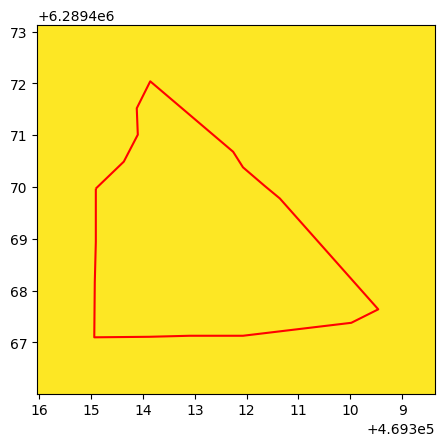

VS269t_122 : WET_VS269t.tif


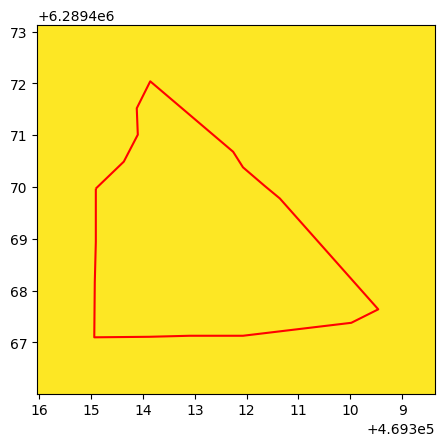

VS269t_2503 : LANDFORM_VS269t.tif


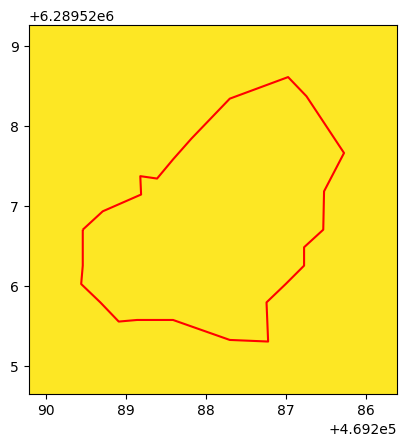

VS269t_2503 : WET_VS269t.tif


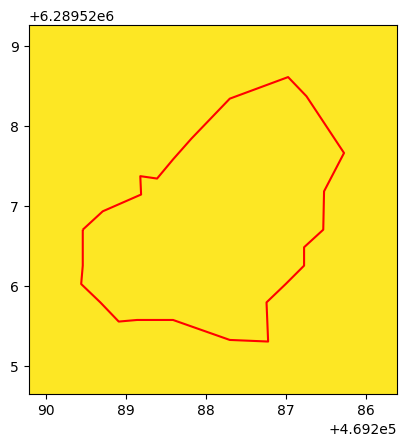

WJ255t_1458 : BAIS2_WJ255t.tif


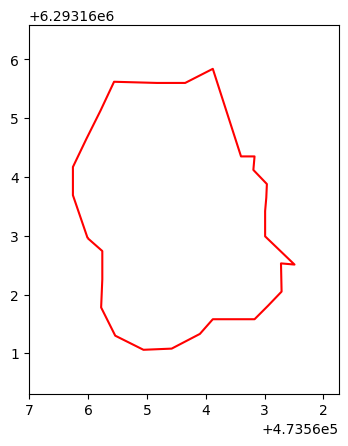

WJ255t_1458 : EVI_WJ255t.tif


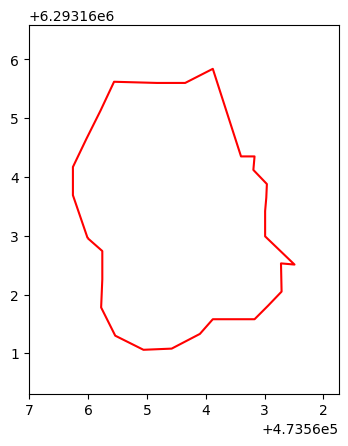

WJ255t_1458 : GCH_WJ255t.tif


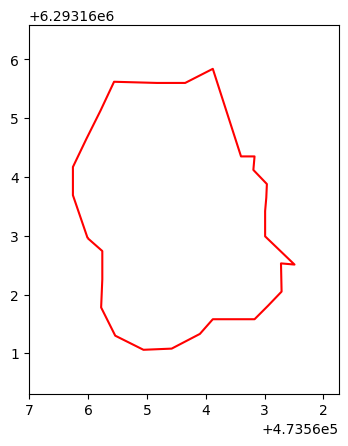

WJ255t_1458 : kEVI_WJ255t.tif


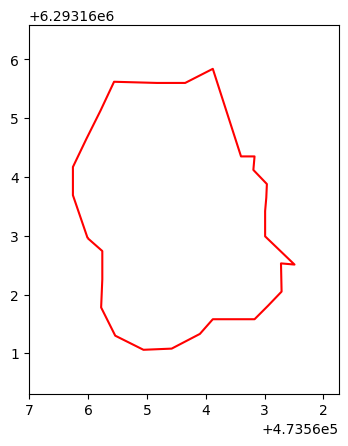

WJ255t_1458 : kIPVI_WJ255t.tif


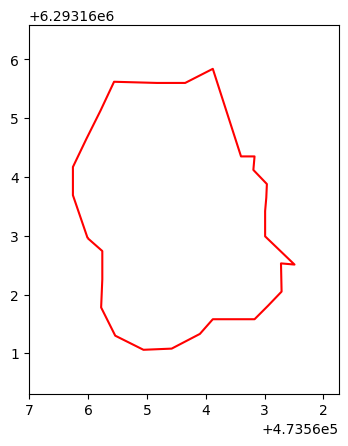

WJ255t_1458 : kNDVI_WJ255t.tif


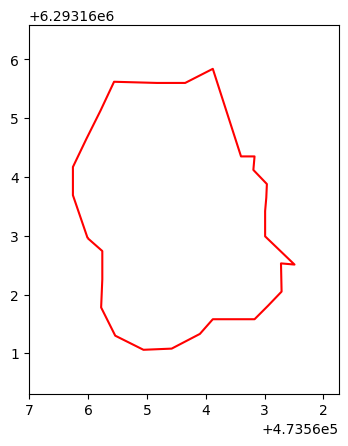

WJ255t_1458 : kRVI_WJ255t.tif


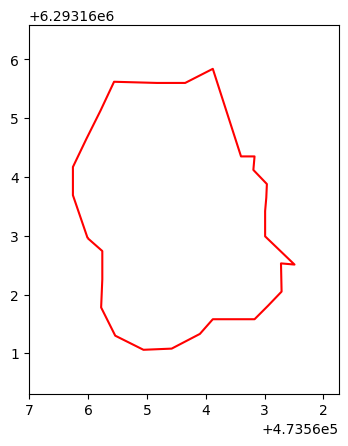

WJ255t_1458 : kVARI_WJ255t.tif


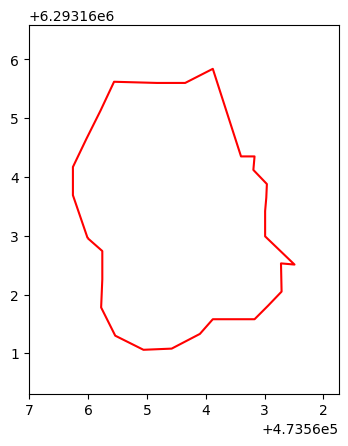

WJ255t_1458 : LANDFORM_WJ255t.tif


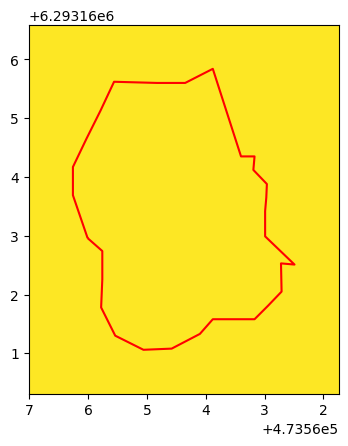

WJ255t_1458 : MIRBI_WJ255t.tif


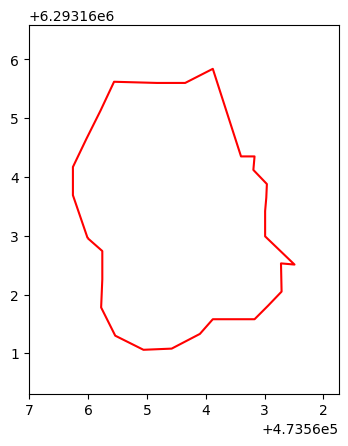

WJ255t_1458 : MSI_WJ255t.tif


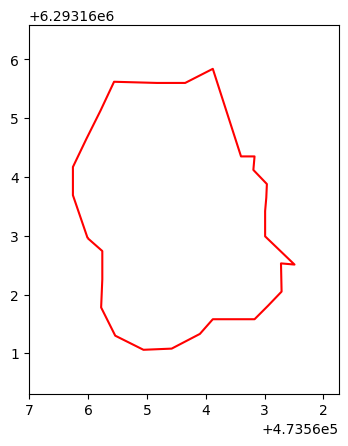

WJ255t_1458 : NBRPLUS_WJ255t.tif


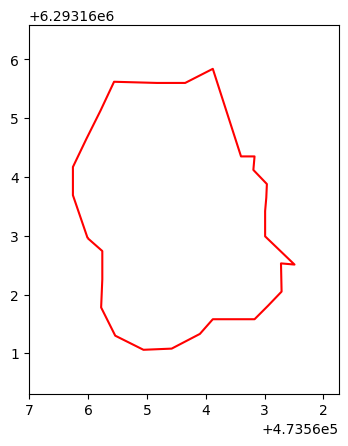

WJ255t_1458 : NBRSWIR_WJ255t.tif


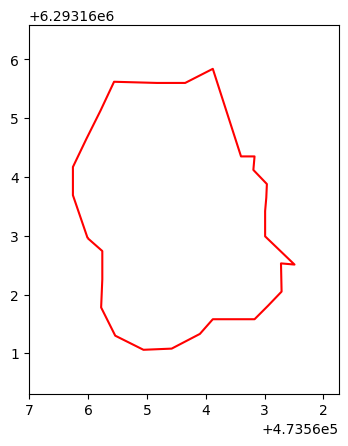

WJ255t_1458 : NBR_WJ255t.tif


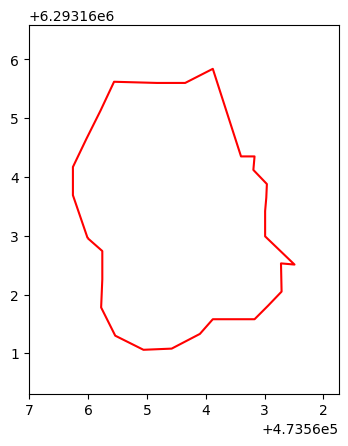

WJ255t_1458 : NDMBWI_WJ255t.tif


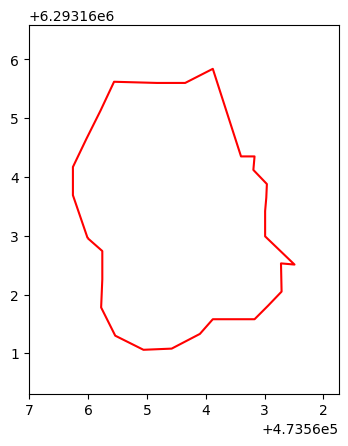

WJ255t_1458 : NDSI_WJ255t.tif


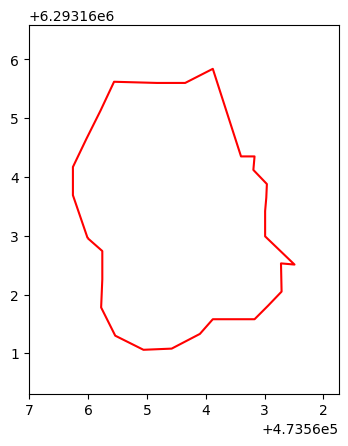

WJ255t_1458 : NDVI_WJ255t.tif


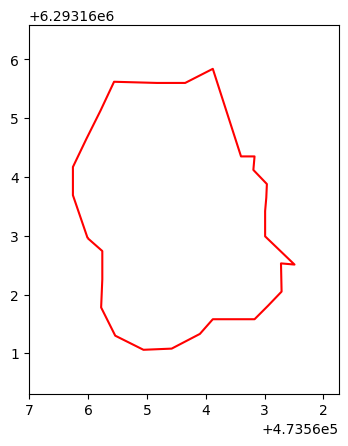

WJ255t_1458 : NDWISWIR1_WJ255t.tif


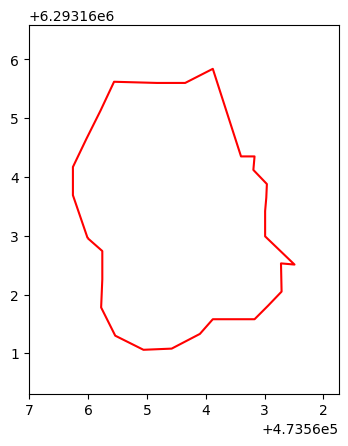

WJ255t_1458 : NDWI_WJ255t.tif


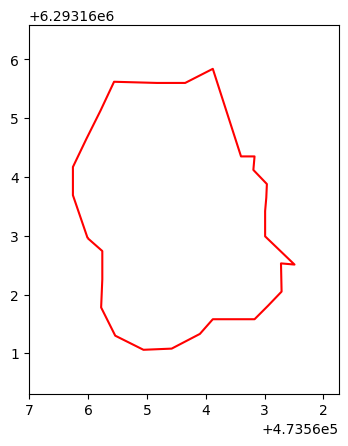

WJ255t_1458 : NR_WJ255t.tif


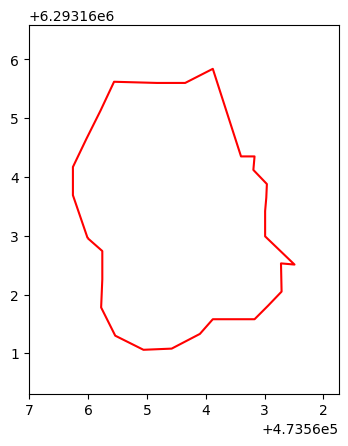

WJ255t_1458 : RDGCH_WJ255t.tif


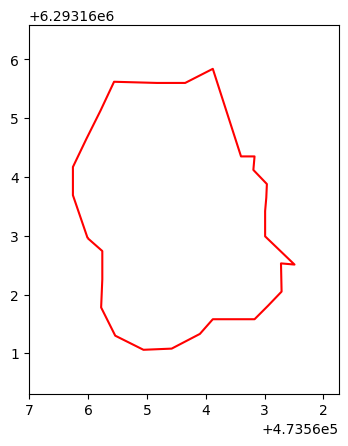

WJ255t_1458 : ReNDVI_WJ255t.tif


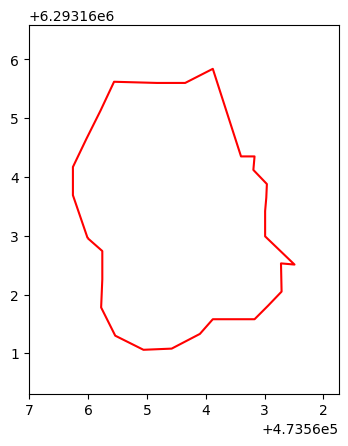

WJ255t_1458 : SAVI_WJ255t.tif


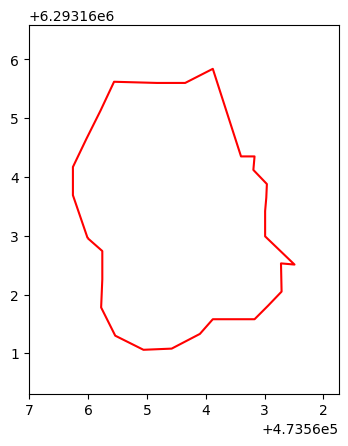

WJ255t_1458 : WET_WJ255t.tif


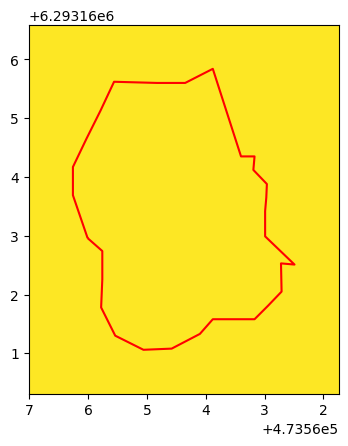

WJ255t_1263 : BAIS2_WJ255t.tif


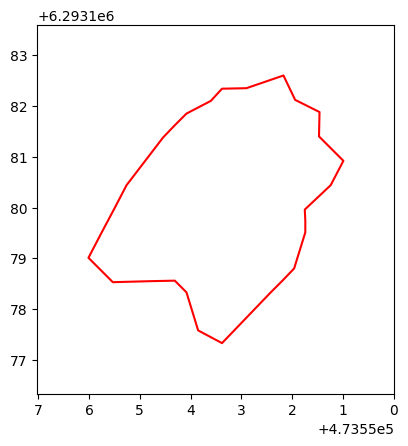

WJ255t_1263 : EVI_WJ255t.tif


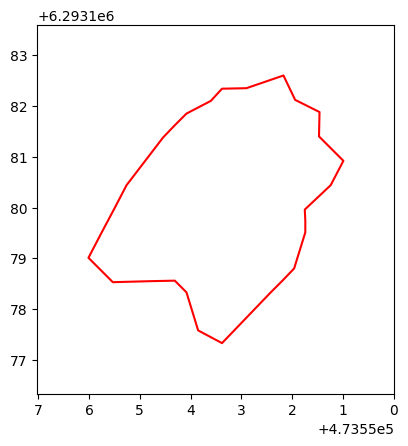

WJ255t_1263 : GCH_WJ255t.tif


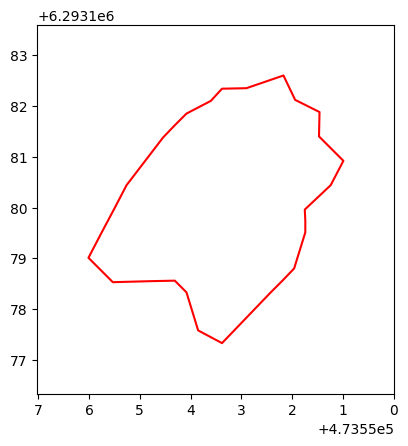

WJ255t_1263 : kEVI_WJ255t.tif


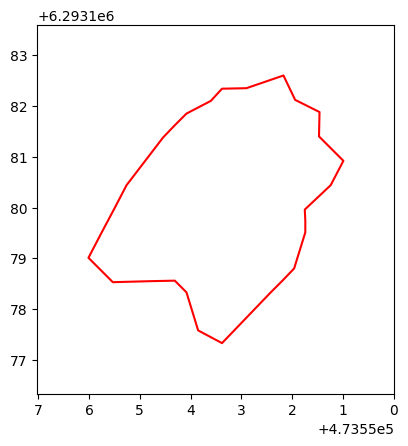

WJ255t_1263 : kIPVI_WJ255t.tif


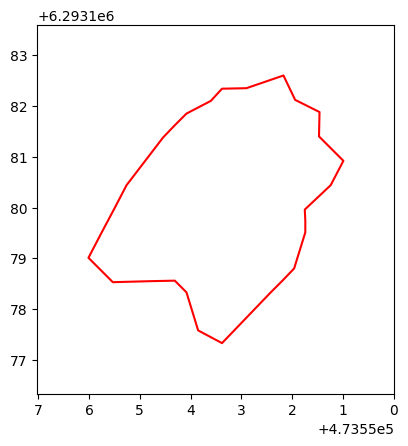

WJ255t_1263 : kNDVI_WJ255t.tif


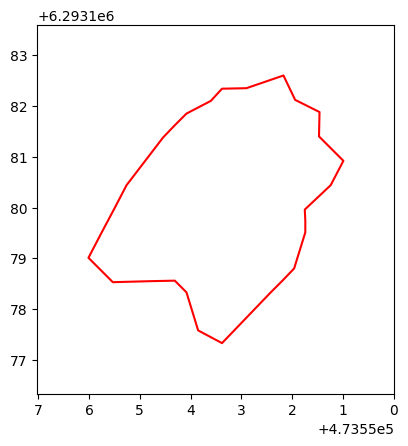

WJ255t_1263 : kRVI_WJ255t.tif


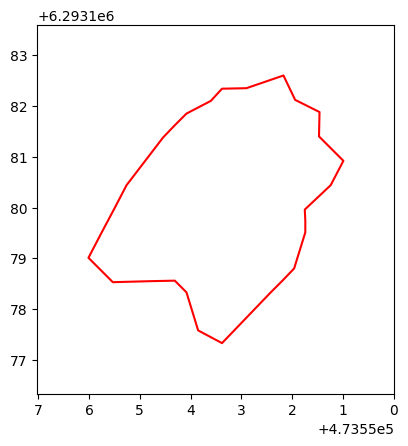

WJ255t_1263 : kVARI_WJ255t.tif


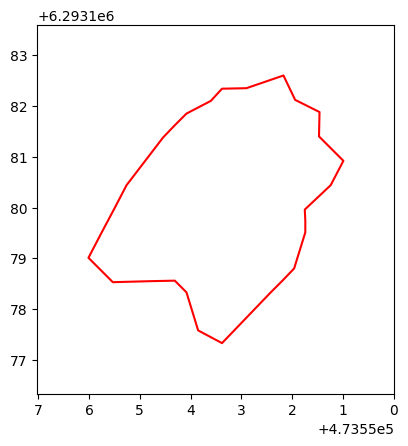

WJ255t_1263 : LANDFORM_WJ255t.tif


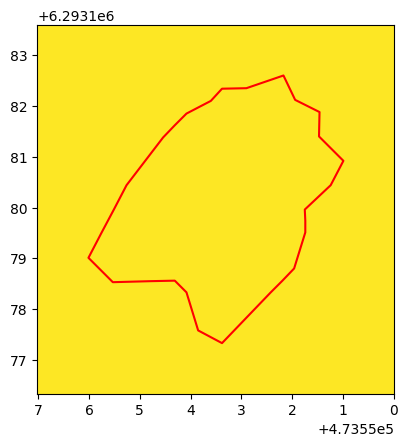

WJ255t_1263 : MIRBI_WJ255t.tif


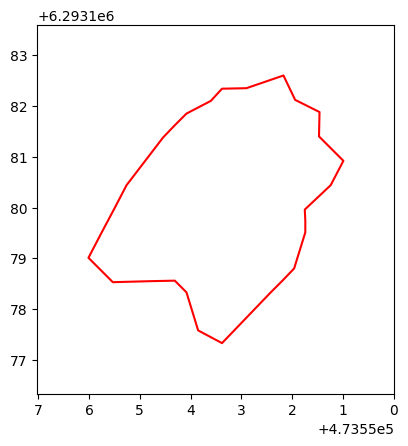

WJ255t_1263 : MSI_WJ255t.tif


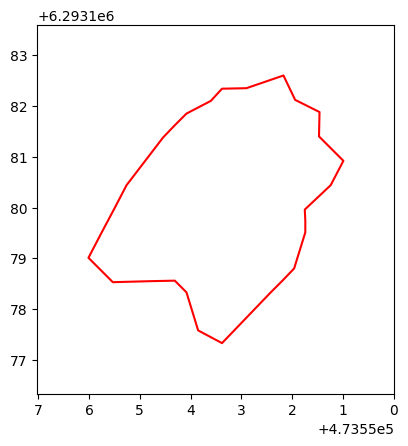

WJ255t_1263 : NBRPLUS_WJ255t.tif


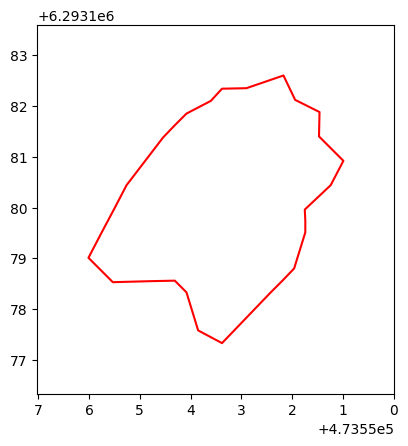

WJ255t_1263 : NBRSWIR_WJ255t.tif


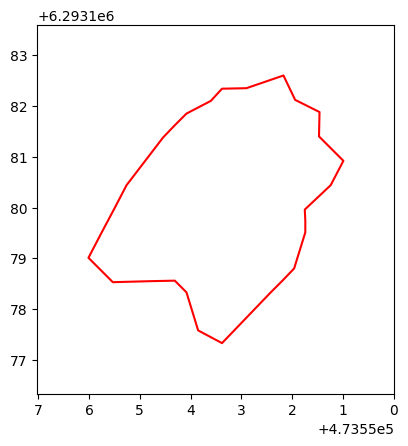

WJ255t_1263 : NBR_WJ255t.tif


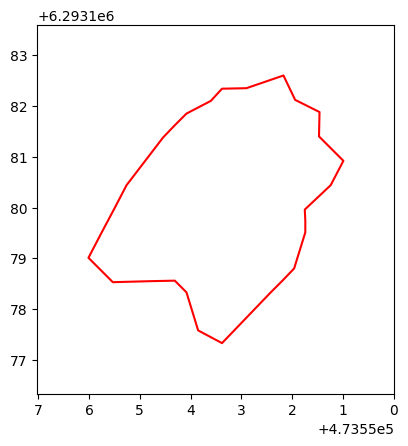

WJ255t_1263 : NDMBWI_WJ255t.tif


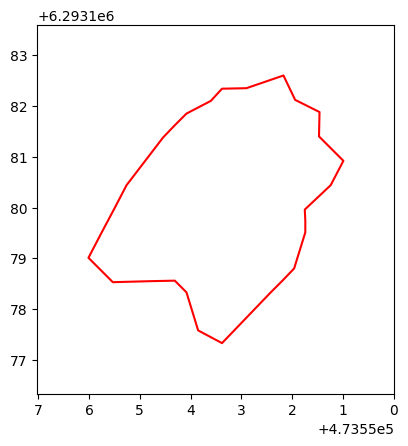

WJ255t_1263 : NDSI_WJ255t.tif


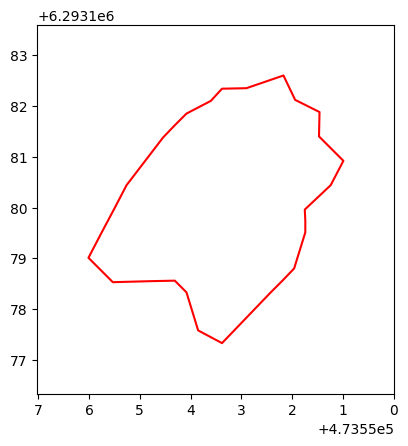

WJ255t_1263 : NDVI_WJ255t.tif


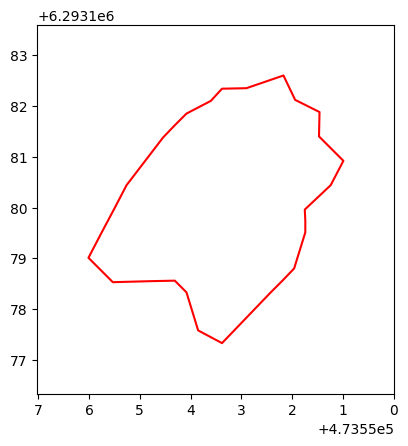

WJ255t_1263 : NDWISWIR1_WJ255t.tif


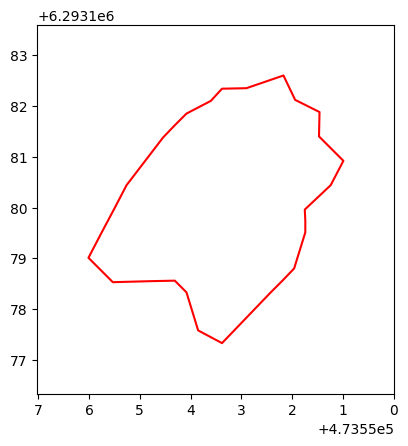

WJ255t_1263 : NDWI_WJ255t.tif


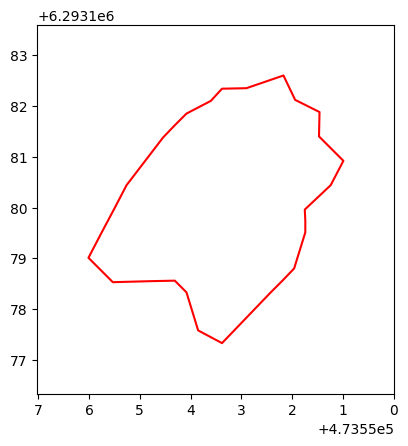

WJ255t_1263 : NR_WJ255t.tif


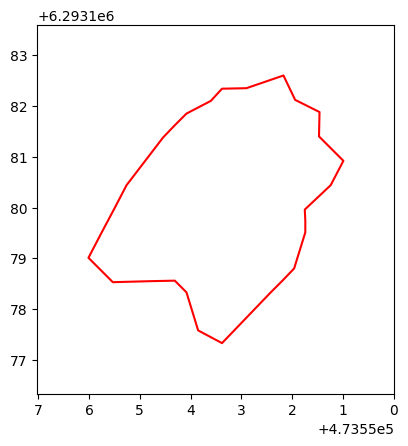

WJ255t_1263 : RDGCH_WJ255t.tif


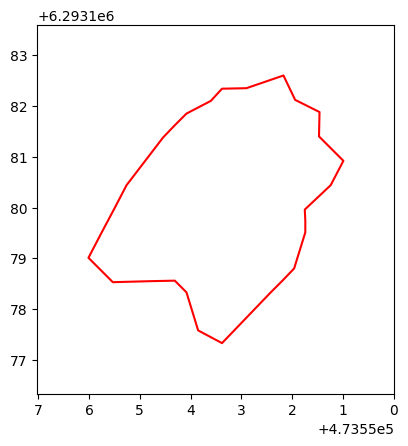

WJ255t_1263 : ReNDVI_WJ255t.tif


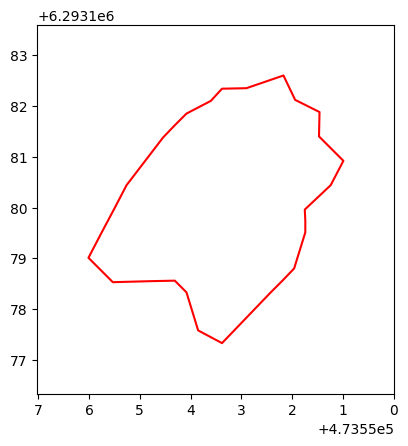

WJ255t_1263 : SAVI_WJ255t.tif


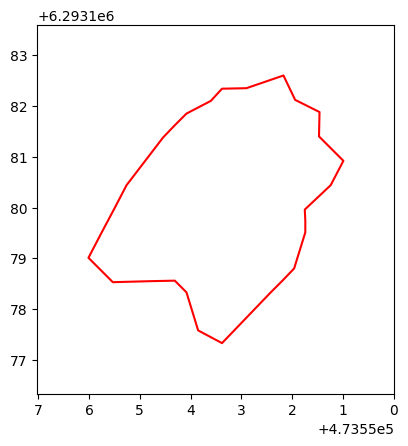

WJ255t_1263 : WET_WJ255t.tif


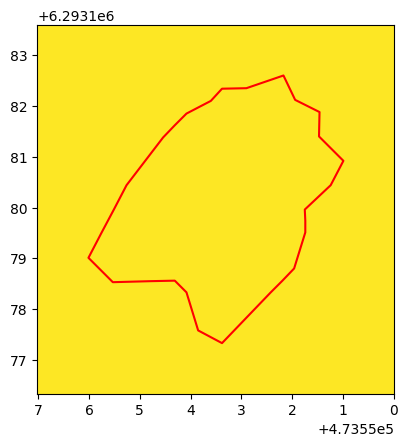

WJ255t_1872 : BAIS2_WJ255t.tif


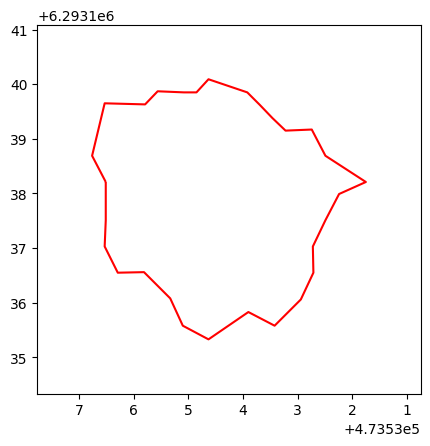

WJ255t_1872 : EVI_WJ255t.tif


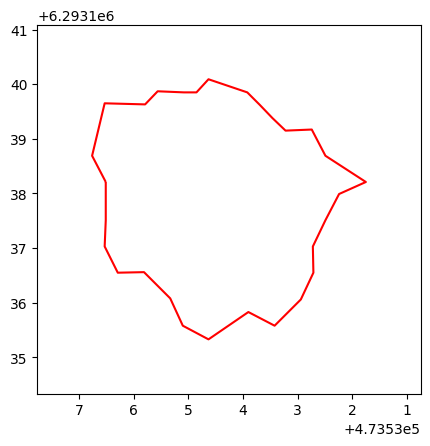

WJ255t_1872 : GCH_WJ255t.tif


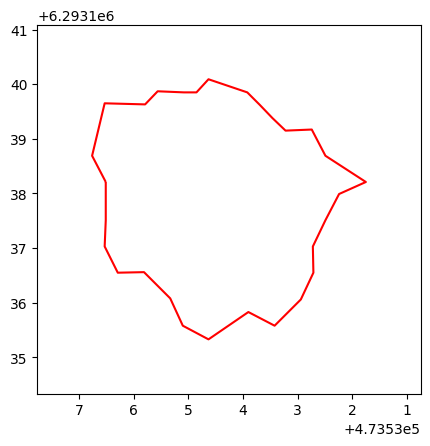

WJ255t_1872 : kEVI_WJ255t.tif


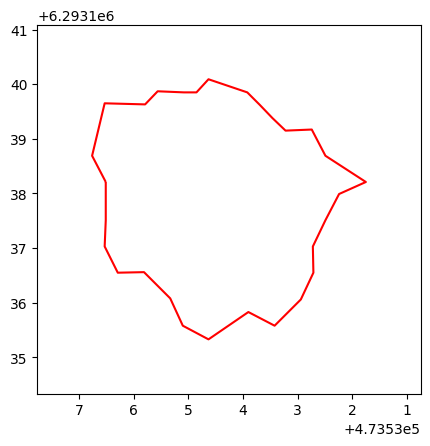

WJ255t_1872 : kIPVI_WJ255t.tif


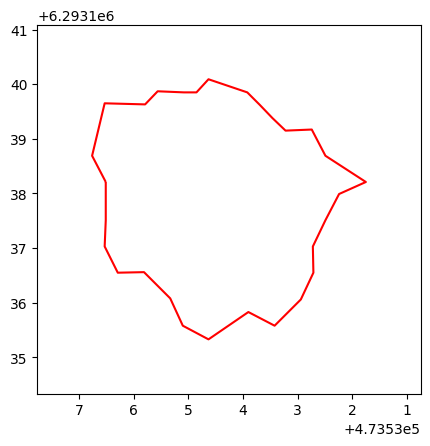

WJ255t_1872 : kNDVI_WJ255t.tif


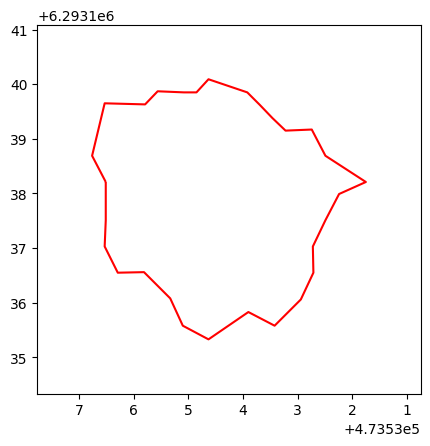

WJ255t_1872 : kRVI_WJ255t.tif


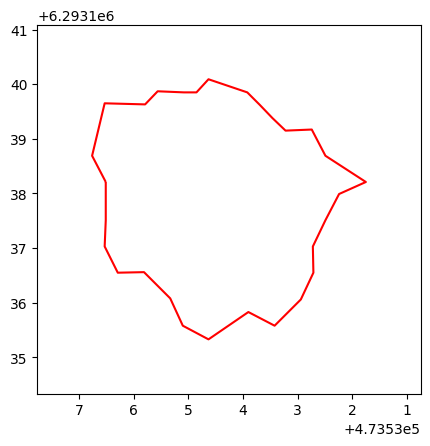

WJ255t_1872 : kVARI_WJ255t.tif


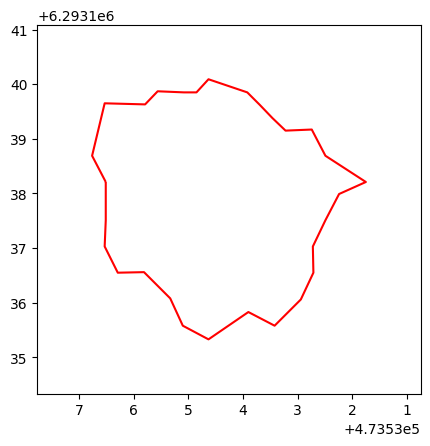

WJ255t_1872 : LANDFORM_WJ255t.tif


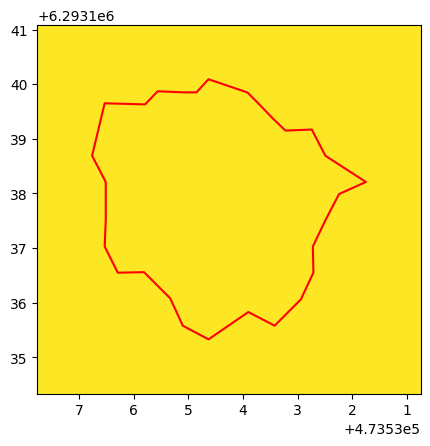

WJ255t_1872 : MIRBI_WJ255t.tif


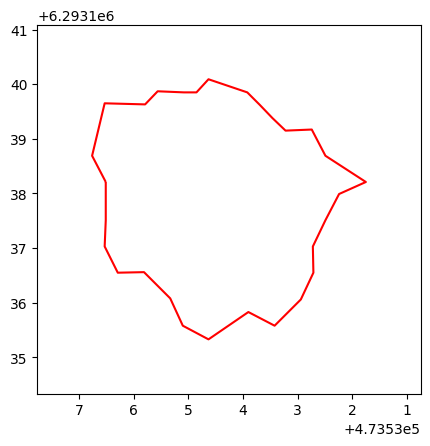

WJ255t_1872 : MSI_WJ255t.tif


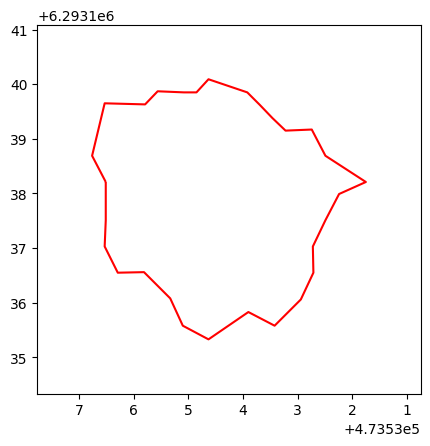

WJ255t_1872 : NBRPLUS_WJ255t.tif


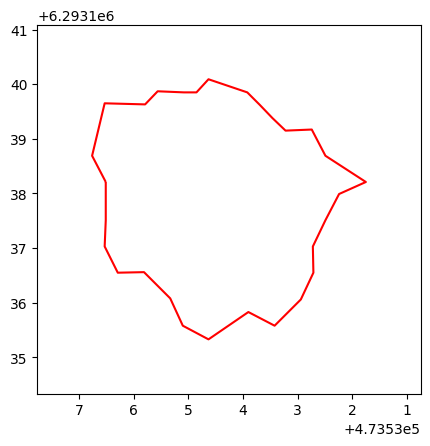

WJ255t_1872 : NBRSWIR_WJ255t.tif


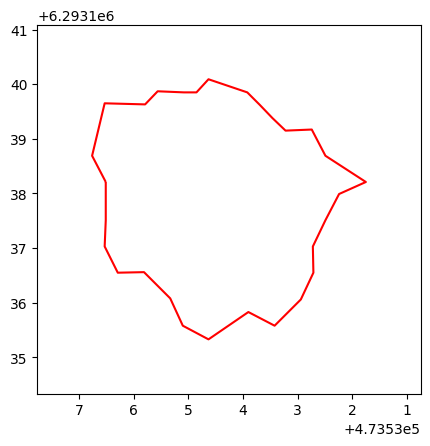

WJ255t_1872 : NBR_WJ255t.tif


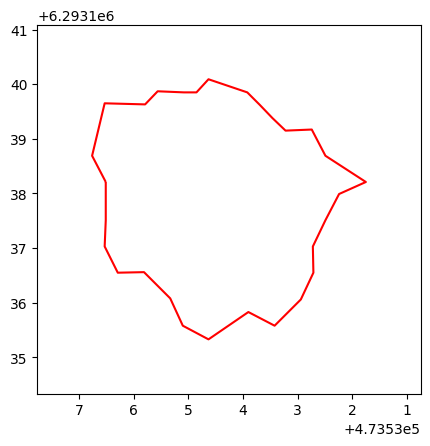

WJ255t_1872 : NDMBWI_WJ255t.tif


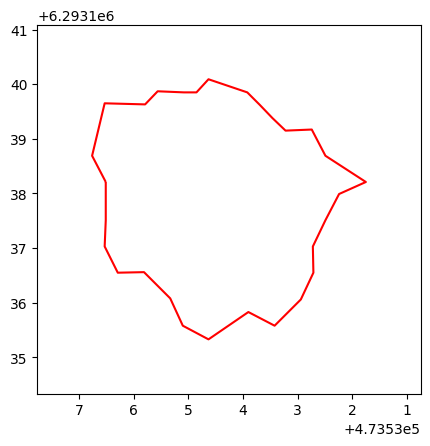

WJ255t_1872 : NDSI_WJ255t.tif


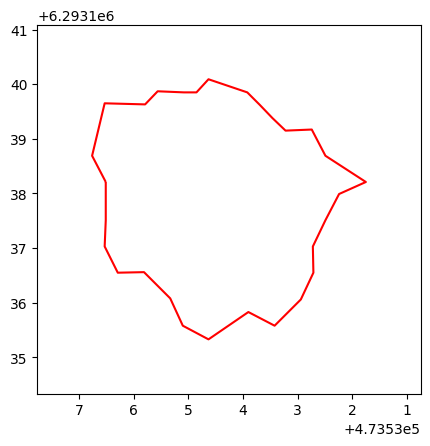

WJ255t_1872 : NDVI_WJ255t.tif


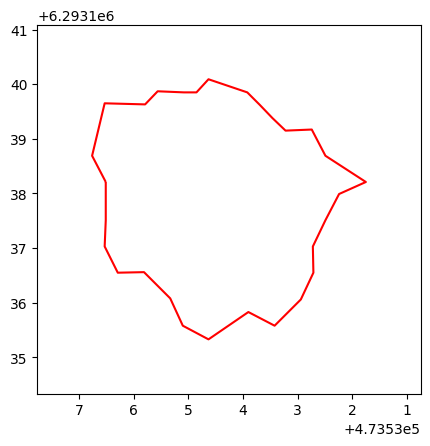

WJ255t_1872 : NDWISWIR1_WJ255t.tif


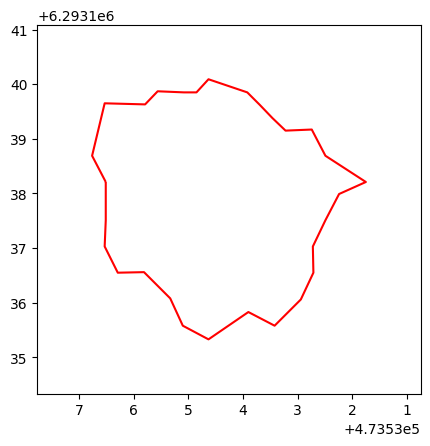

WJ255t_1872 : NDWI_WJ255t.tif


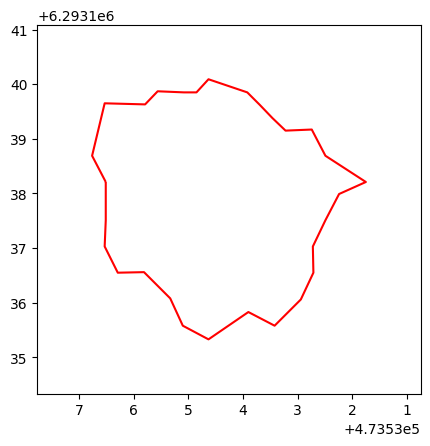

WJ255t_1872 : NR_WJ255t.tif


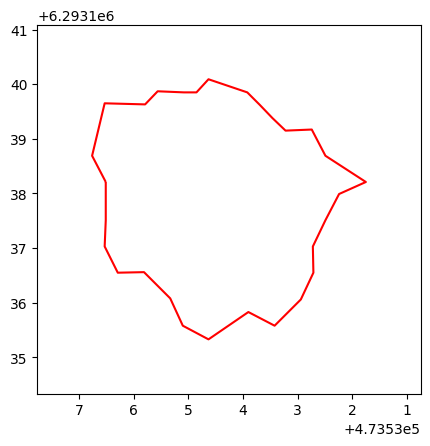

WJ255t_1872 : RDGCH_WJ255t.tif


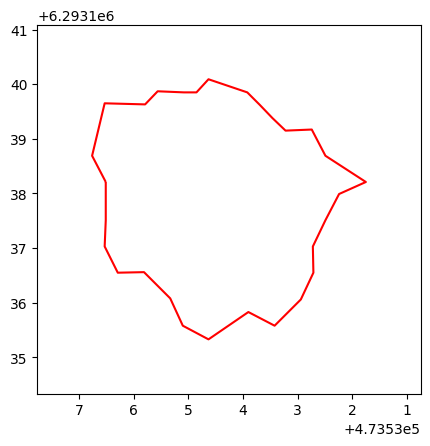

WJ255t_1872 : ReNDVI_WJ255t.tif


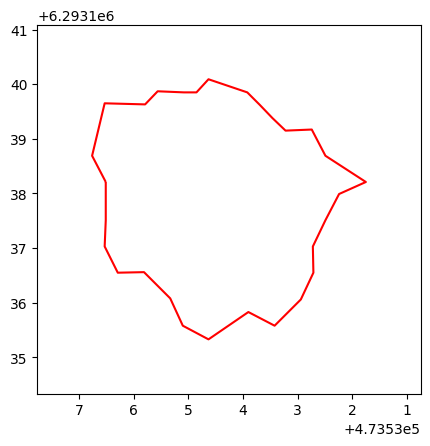

WJ255t_1872 : SAVI_WJ255t.tif


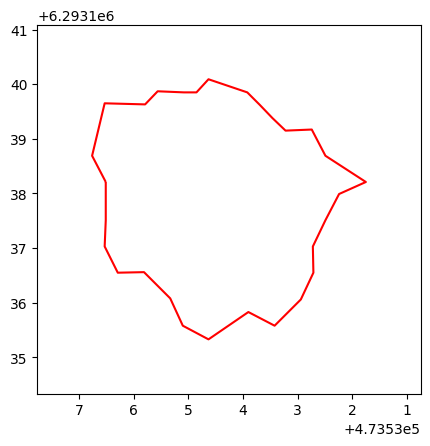

WJ255t_1872 : WET_WJ255t.tif


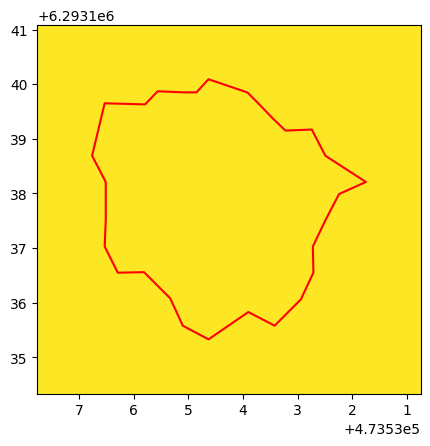

WJ255t_58 : BAIS2_WJ255t.tif


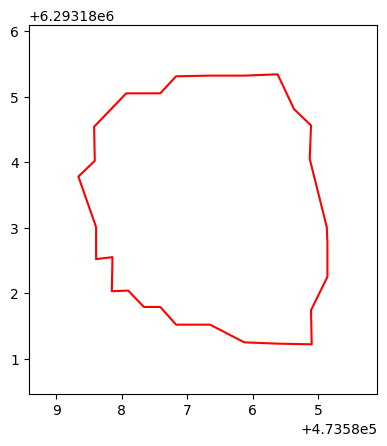

WJ255t_58 : EVI_WJ255t.tif


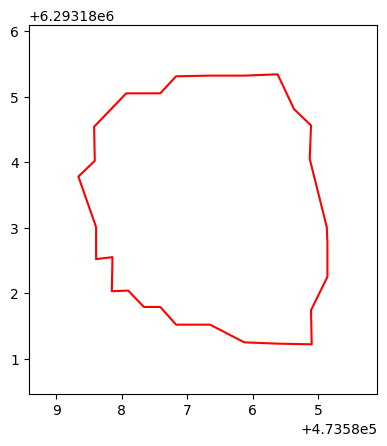

WJ255t_58 : GCH_WJ255t.tif


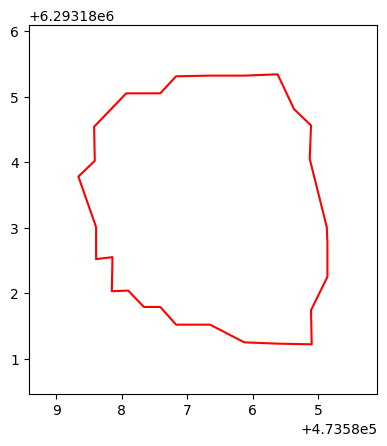

WJ255t_58 : kEVI_WJ255t.tif


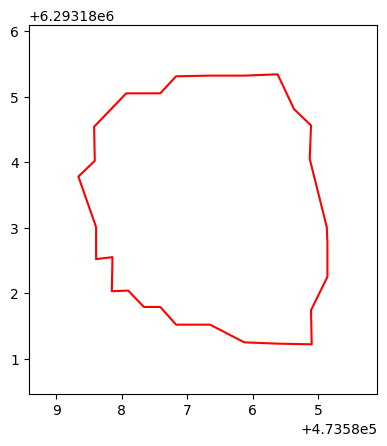

WJ255t_58 : kIPVI_WJ255t.tif


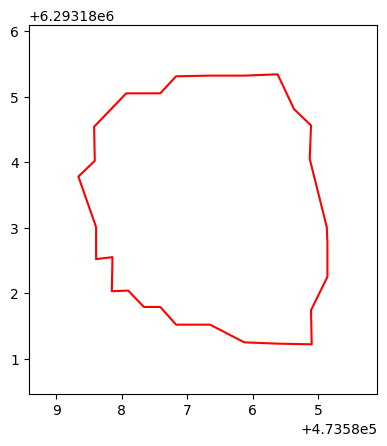

WJ255t_58 : kNDVI_WJ255t.tif


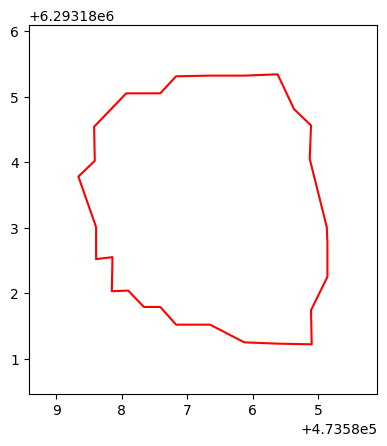

WJ255t_58 : kRVI_WJ255t.tif


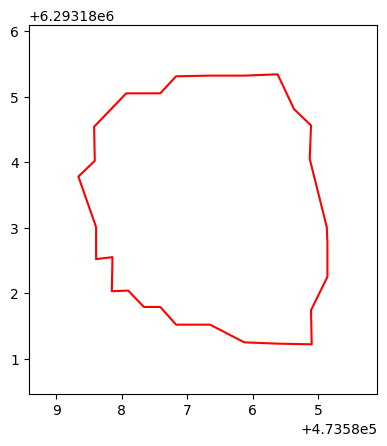

WJ255t_58 : kVARI_WJ255t.tif


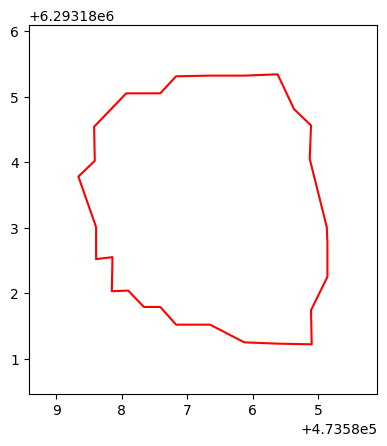

WJ255t_58 : LANDFORM_WJ255t.tif


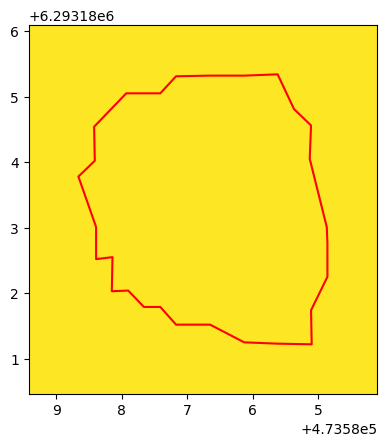

WJ255t_58 : MIRBI_WJ255t.tif


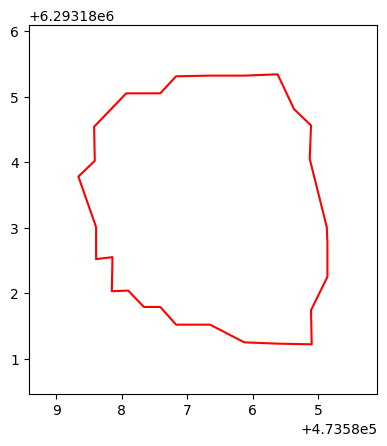

WJ255t_58 : MSI_WJ255t.tif


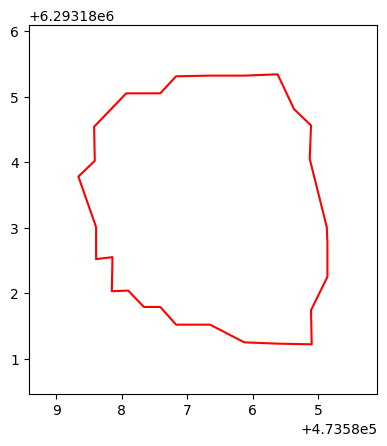

WJ255t_58 : NBRPLUS_WJ255t.tif


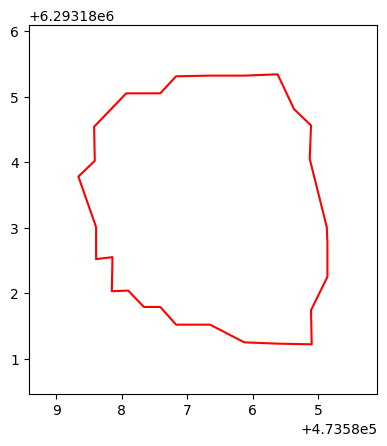

WJ255t_58 : NBRSWIR_WJ255t.tif


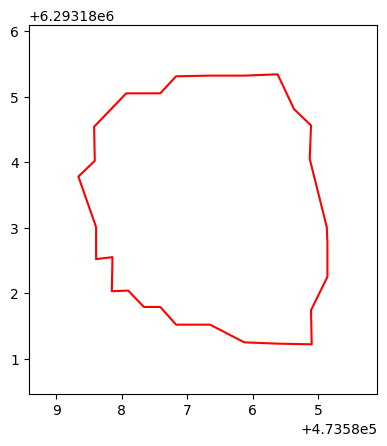

WJ255t_58 : NBR_WJ255t.tif


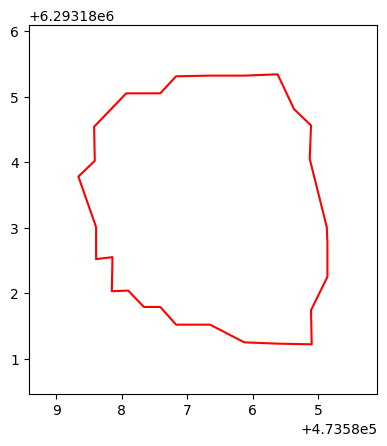

WJ255t_58 : NDMBWI_WJ255t.tif


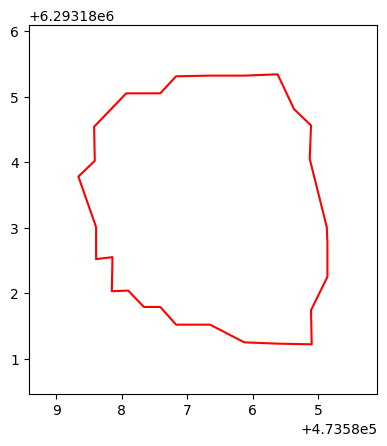

WJ255t_58 : NDSI_WJ255t.tif


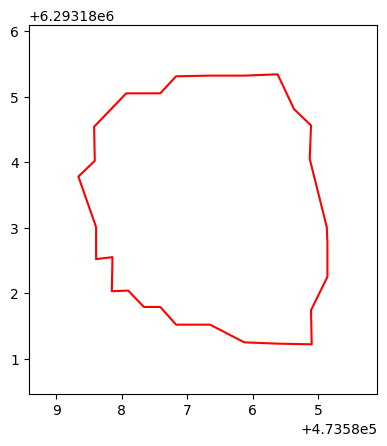

WJ255t_58 : NDVI_WJ255t.tif


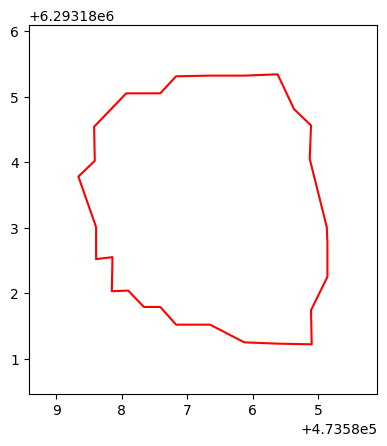

WJ255t_58 : NDWISWIR1_WJ255t.tif


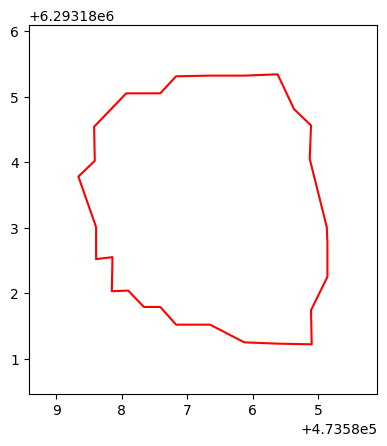

WJ255t_58 : NDWI_WJ255t.tif


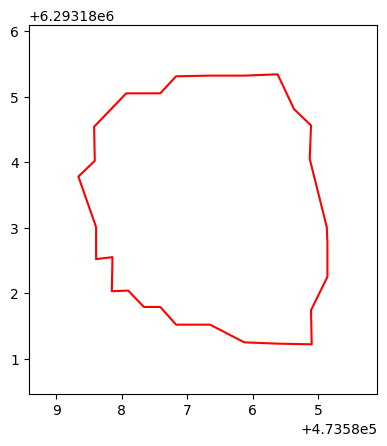

WJ255t_58 : NR_WJ255t.tif


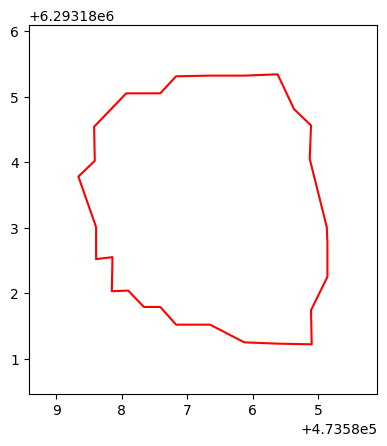

WJ255t_58 : RDGCH_WJ255t.tif


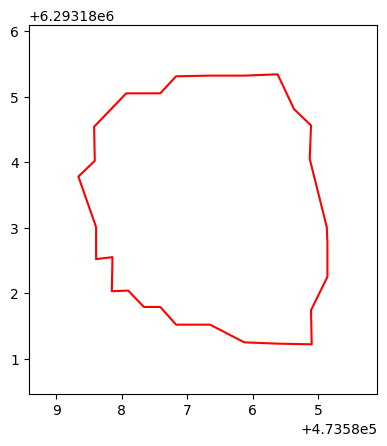

WJ255t_58 : ReNDVI_WJ255t.tif


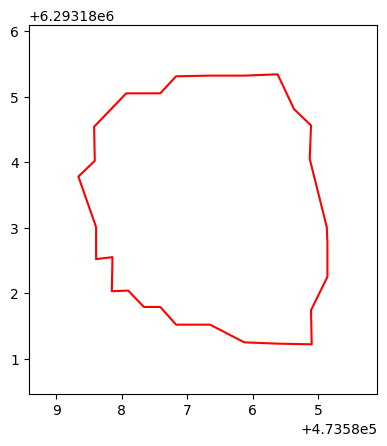

WJ255t_58 : SAVI_WJ255t.tif


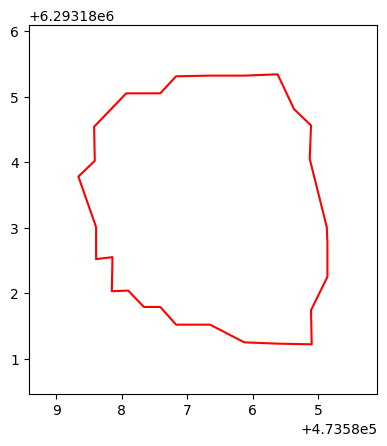

WJ255t_58 : WET_WJ255t.tif


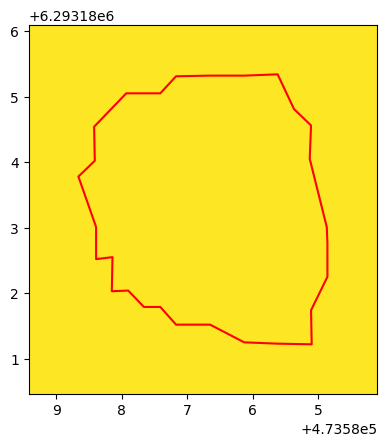

WJ255t_342 : BAIS2_WJ255t.tif


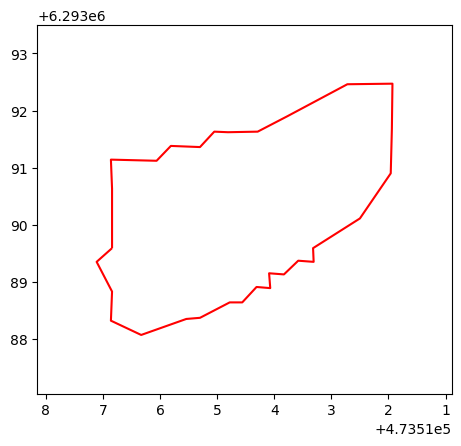

WJ255t_342 : EVI_WJ255t.tif


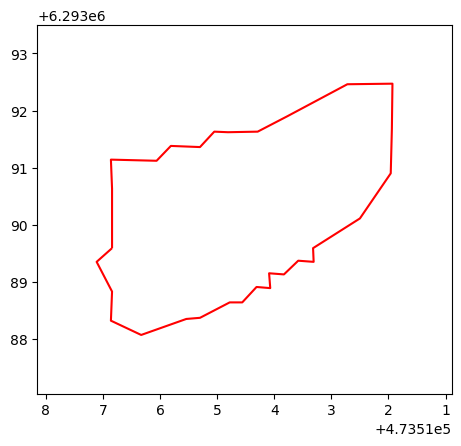

WJ255t_342 : GCH_WJ255t.tif


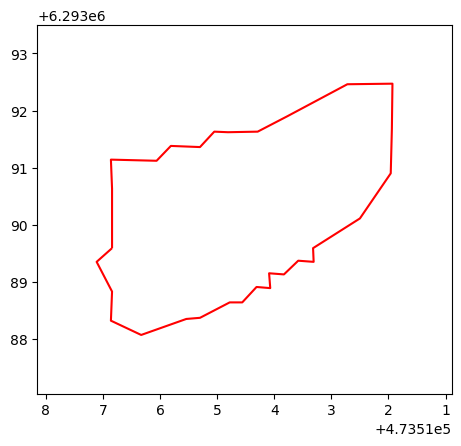

WJ255t_342 : kEVI_WJ255t.tif


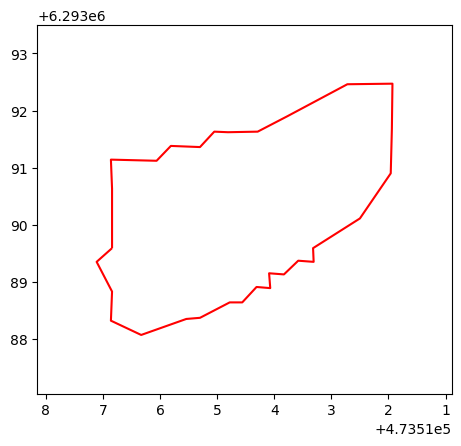

WJ255t_342 : kIPVI_WJ255t.tif


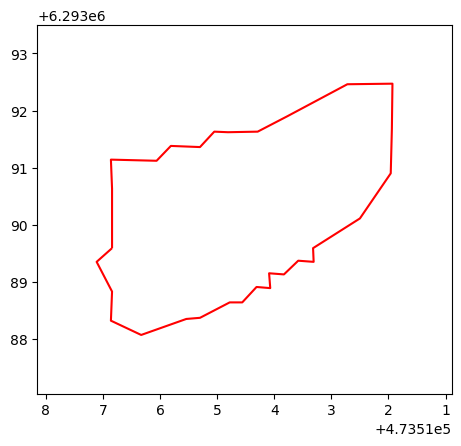

WJ255t_342 : kNDVI_WJ255t.tif


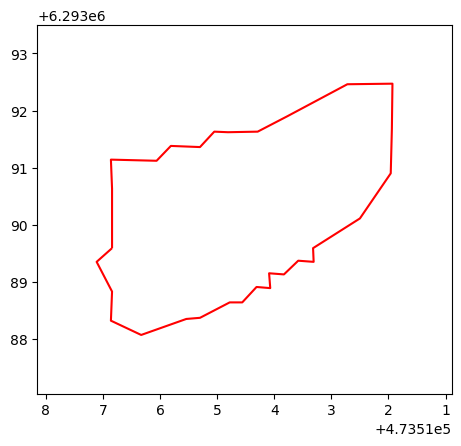

WJ255t_342 : kRVI_WJ255t.tif


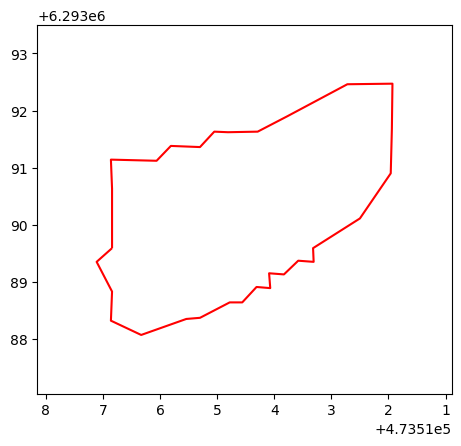

WJ255t_342 : kVARI_WJ255t.tif


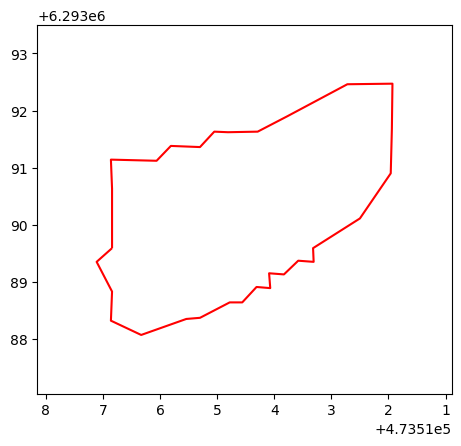

WJ255t_342 : LANDFORM_WJ255t.tif


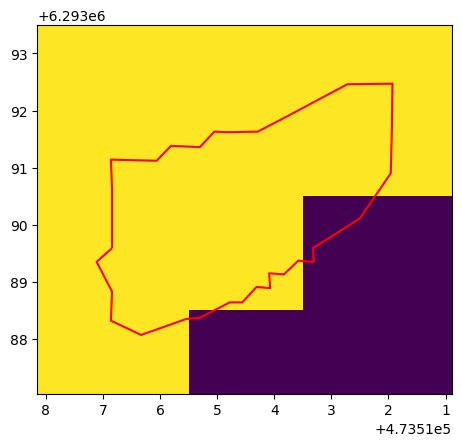

WJ255t_342 : MIRBI_WJ255t.tif


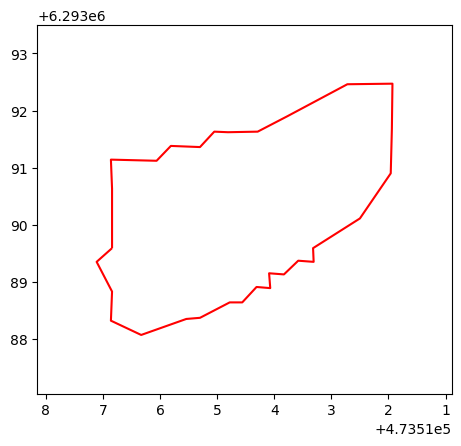

WJ255t_342 : MSI_WJ255t.tif


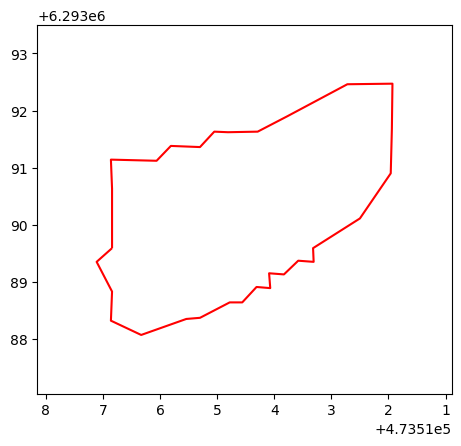

WJ255t_342 : NBRPLUS_WJ255t.tif


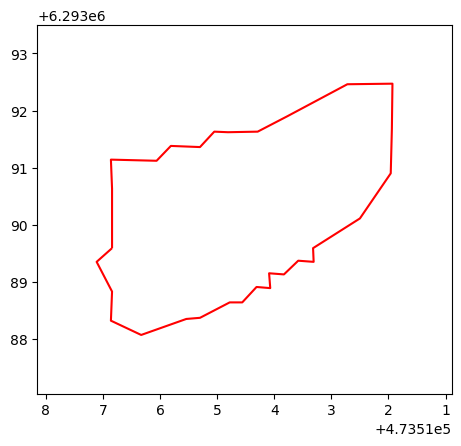

WJ255t_342 : NBRSWIR_WJ255t.tif


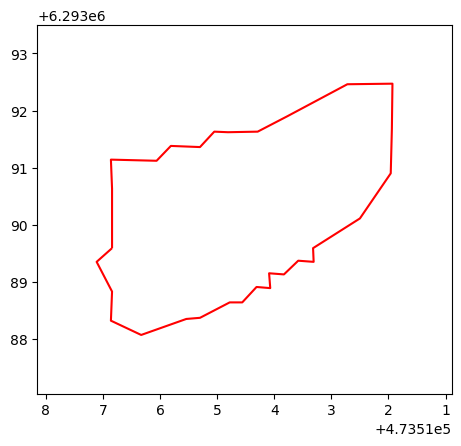

WJ255t_342 : NBR_WJ255t.tif


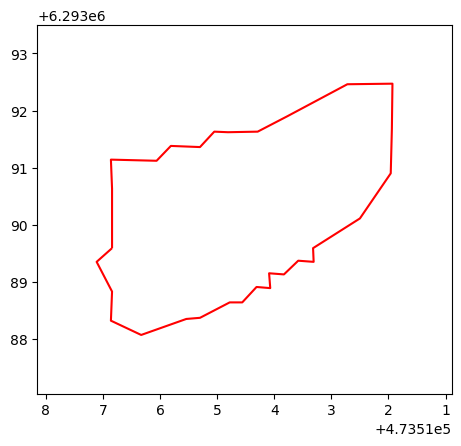

WJ255t_342 : NDMBWI_WJ255t.tif


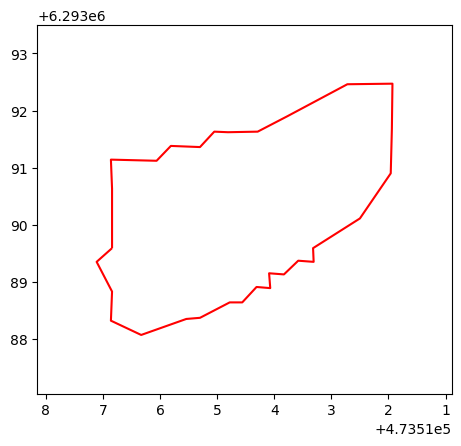

WJ255t_342 : NDSI_WJ255t.tif


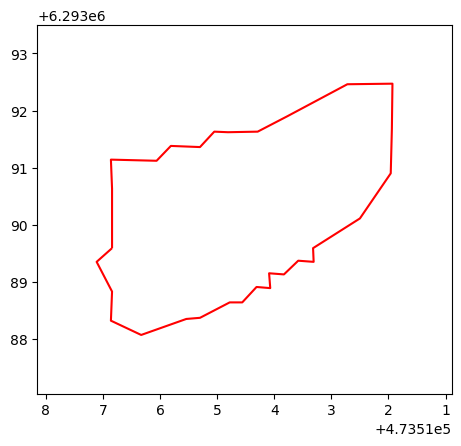

WJ255t_342 : NDVI_WJ255t.tif


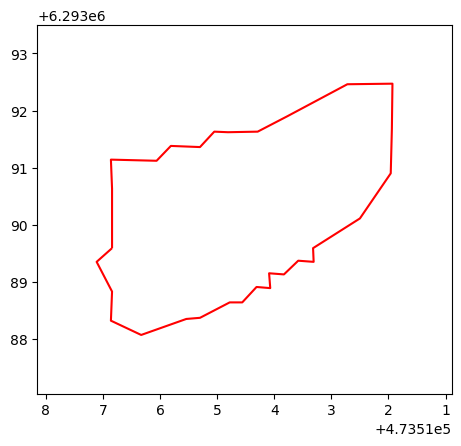

WJ255t_342 : NDWISWIR1_WJ255t.tif


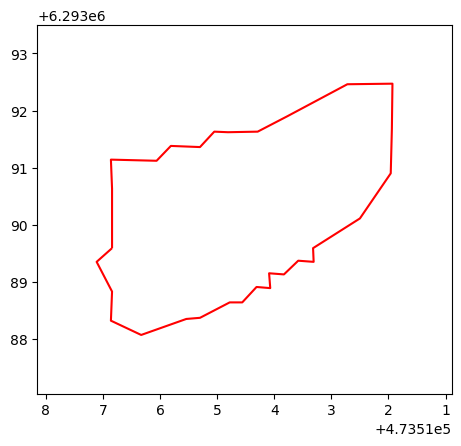

WJ255t_342 : NDWI_WJ255t.tif


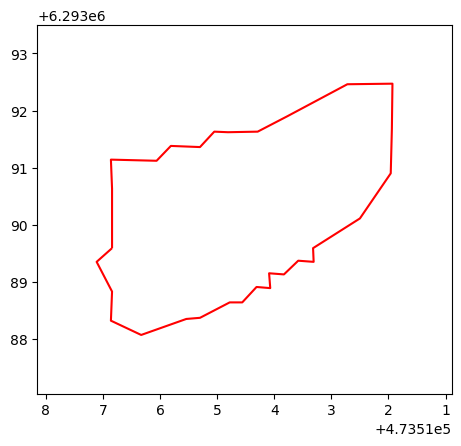

WJ255t_342 : NR_WJ255t.tif


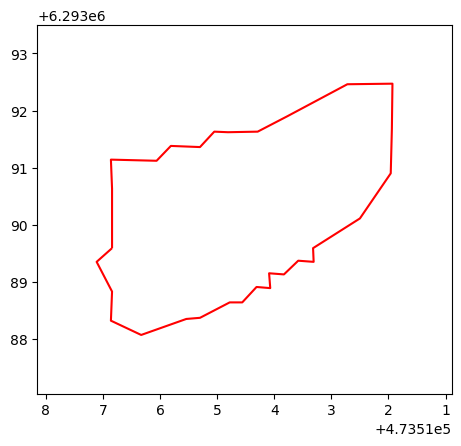

WJ255t_342 : RDGCH_WJ255t.tif


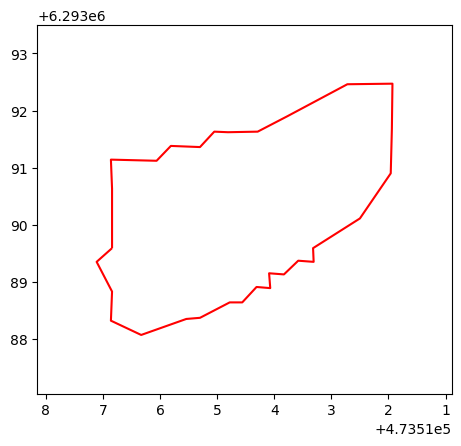

WJ255t_342 : ReNDVI_WJ255t.tif


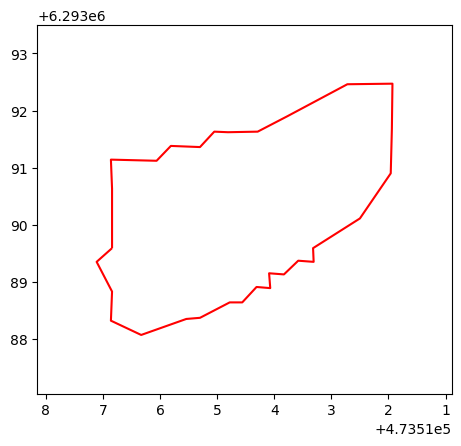

WJ255t_342 : SAVI_WJ255t.tif


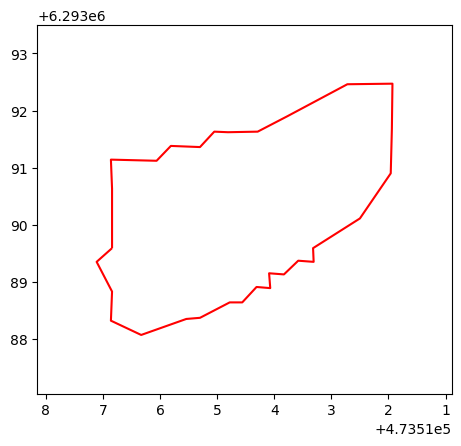

WJ255t_342 : WET_WJ255t.tif


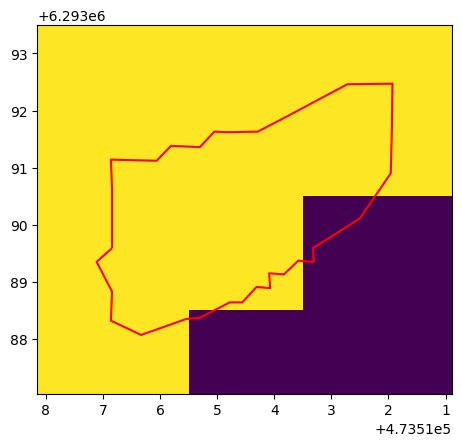

WJ255t_2355 : BAIS2_WJ255t.tif


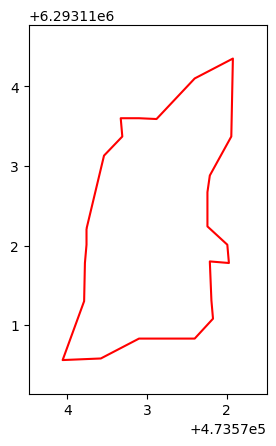

WJ255t_2355 : EVI_WJ255t.tif


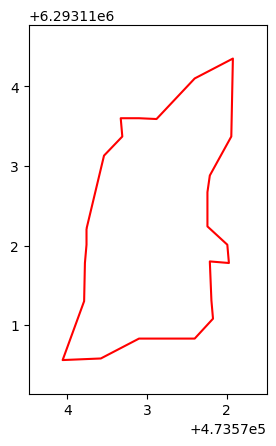

WJ255t_2355 : GCH_WJ255t.tif


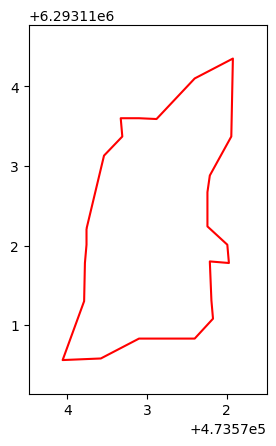

WJ255t_2355 : kEVI_WJ255t.tif


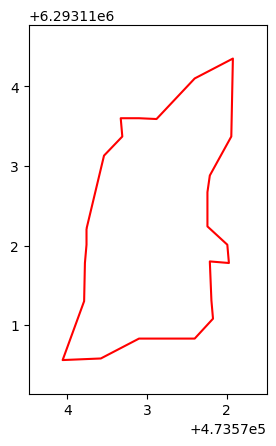

WJ255t_2355 : kIPVI_WJ255t.tif


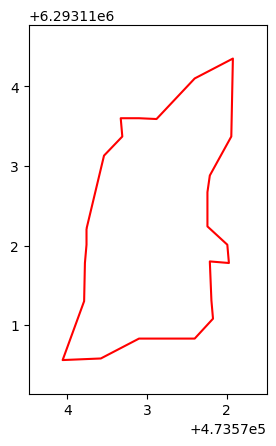

WJ255t_2355 : kNDVI_WJ255t.tif


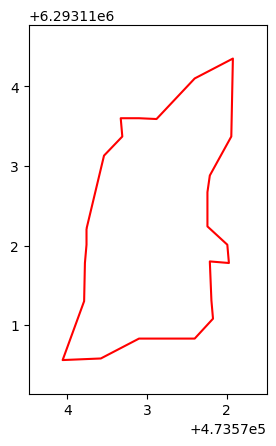

WJ255t_2355 : kRVI_WJ255t.tif


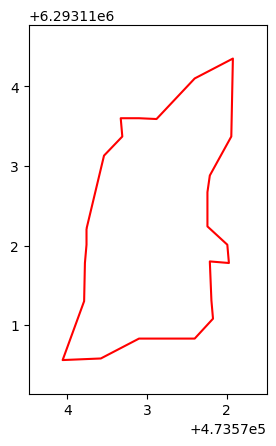

WJ255t_2355 : kVARI_WJ255t.tif


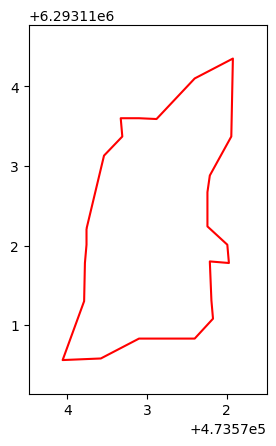

WJ255t_2355 : LANDFORM_WJ255t.tif


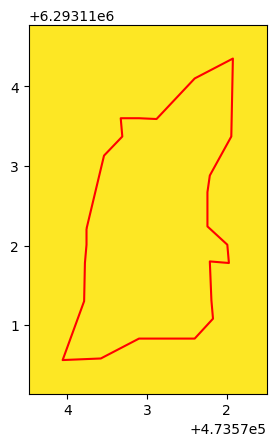

WJ255t_2355 : MIRBI_WJ255t.tif


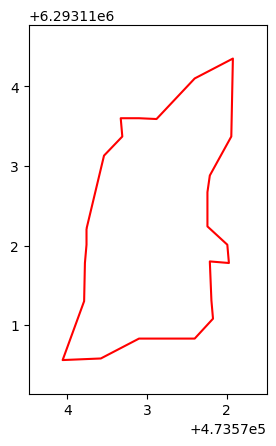

WJ255t_2355 : MSI_WJ255t.tif


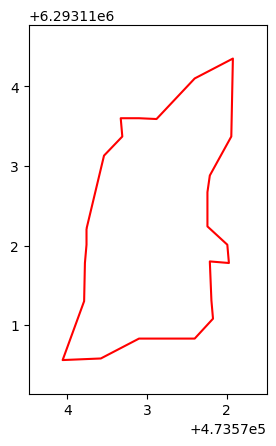

WJ255t_2355 : NBRPLUS_WJ255t.tif


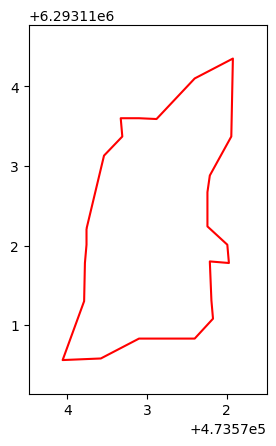

WJ255t_2355 : NBRSWIR_WJ255t.tif


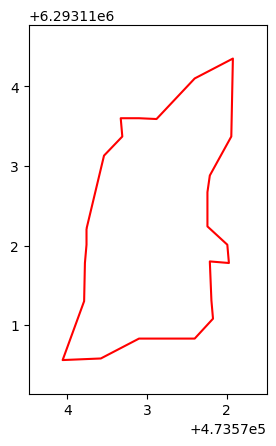

WJ255t_2355 : NBR_WJ255t.tif


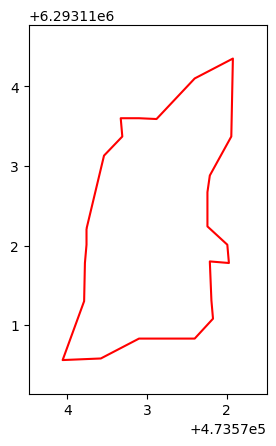

WJ255t_2355 : NDMBWI_WJ255t.tif


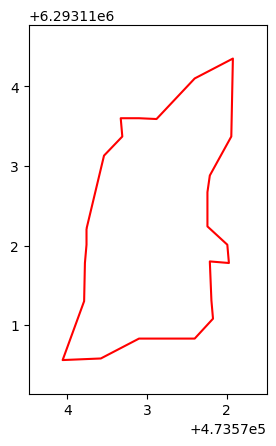

WJ255t_2355 : NDSI_WJ255t.tif


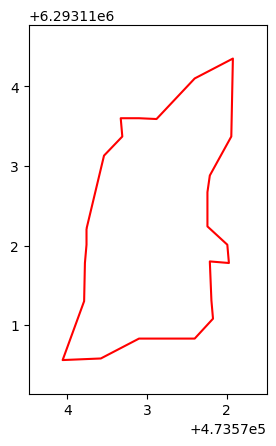

WJ255t_2355 : NDVI_WJ255t.tif


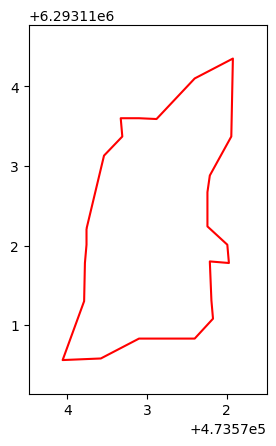

WJ255t_2355 : NDWISWIR1_WJ255t.tif


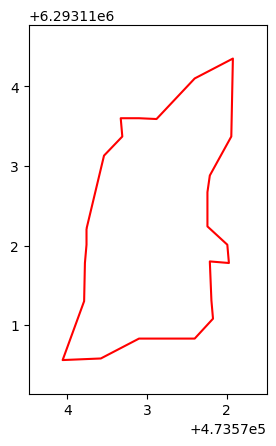

WJ255t_2355 : NDWI_WJ255t.tif


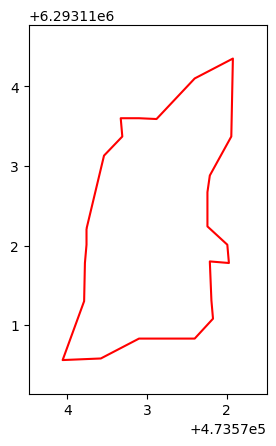

WJ255t_2355 : NR_WJ255t.tif


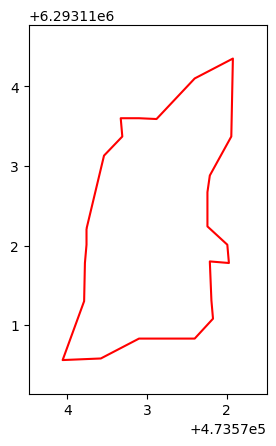

WJ255t_2355 : RDGCH_WJ255t.tif


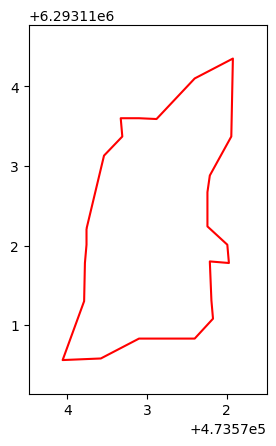

WJ255t_2355 : ReNDVI_WJ255t.tif


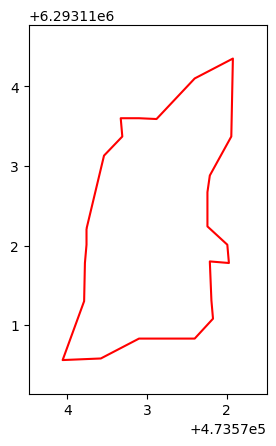

WJ255t_2355 : SAVI_WJ255t.tif


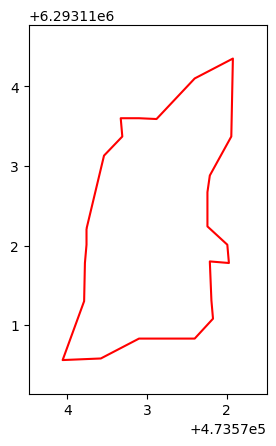

WJ255t_2355 : WET_WJ255t.tif


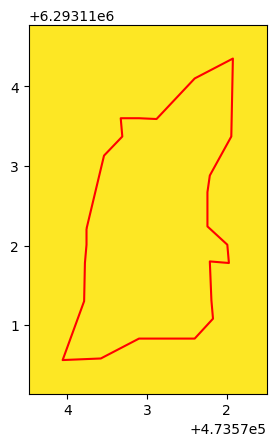

XX1442t_32 : CompositeVH_2023_LeavesOff_XX1442t.tif


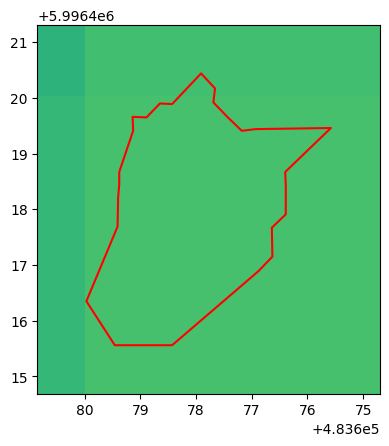

XX1442t_32 : CompositeVH_2023_LeavesOn_XX1442t.tif


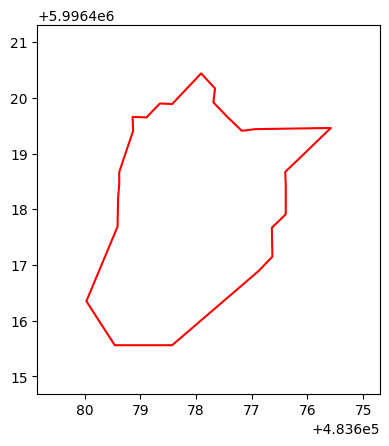

XX1442t_32 : CompositeVV_2023_LeavesOff_XX1442t.tif


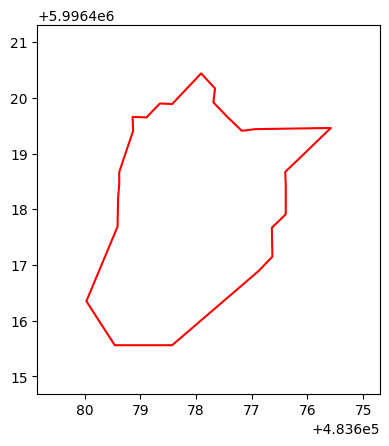

XX1442t_32 : CompositeVV_2023_LeavesOn_XX1442t.tif


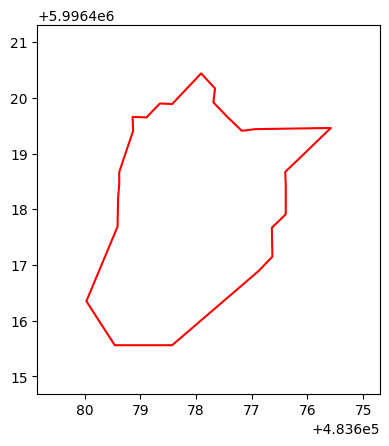

XX1442t_32 : DpRVIVV_2023_LeavesOff_XX1442t.tif


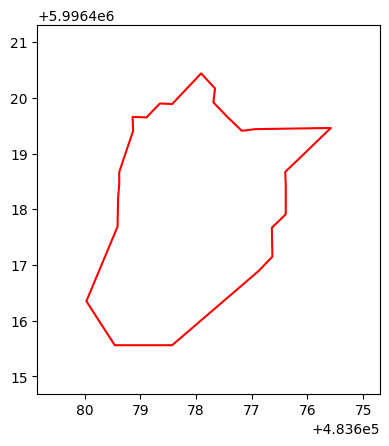

XX1442t_32 : DpRVIVV_2023_LeavesOn_XX1442t.tif


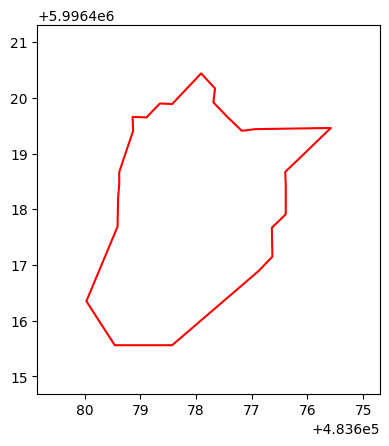

XX1442t_32 : LANDFORM_XX1442t.tif


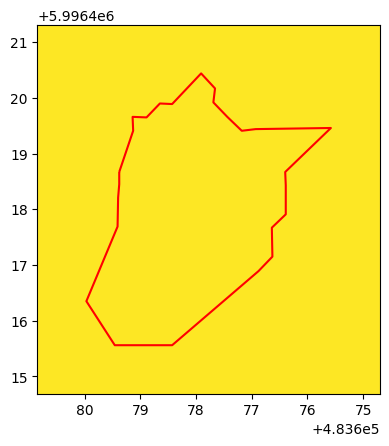

XX1442t_32 : NDPolI_2023_LeavesOff_XX1442t.tif


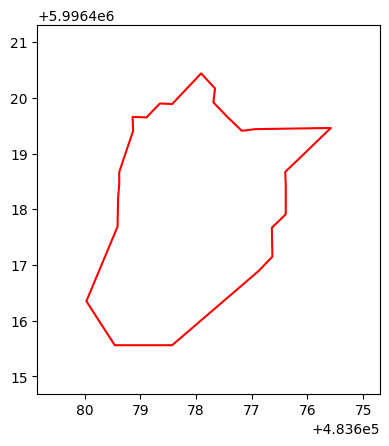

XX1442t_32 : NDPolI_2023_LeavesOn_XX1442t.tif


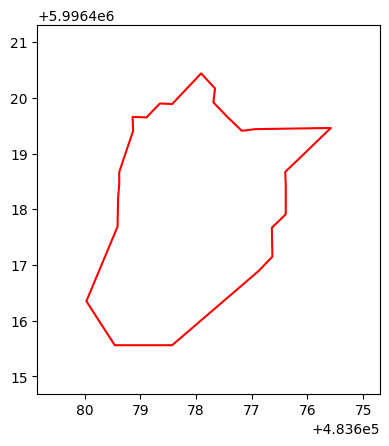

XX1442t_32 : VDDPI_2023_LeavesOff_XX1442t.tif


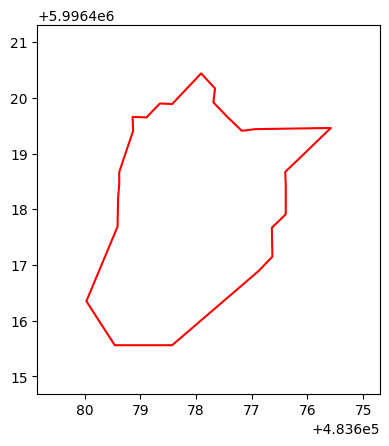

XX1442t_32 : VDDPI_2023_LeavesOn_XX1442t.tif


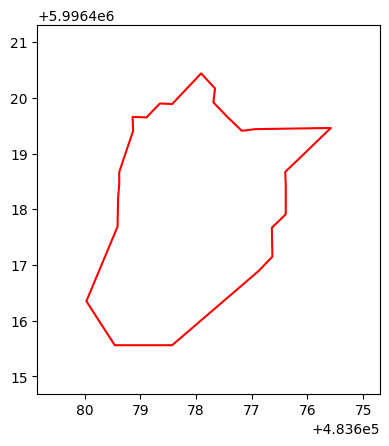

XX1442t_223 : CompositeVH_2023_LeavesOff_XX1442t.tif


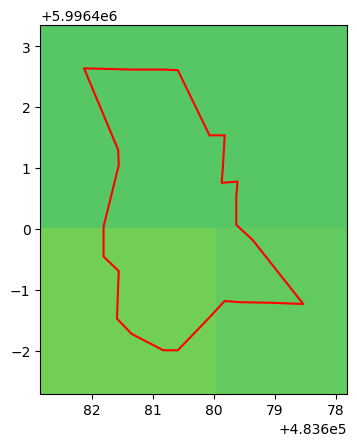

XX1442t_223 : CompositeVH_2023_LeavesOn_XX1442t.tif


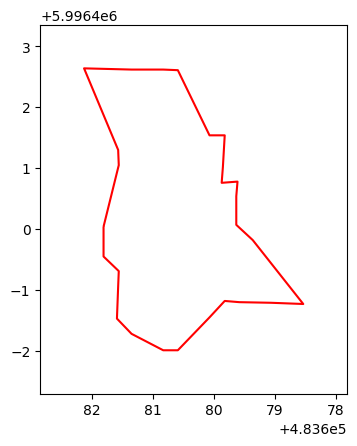

XX1442t_223 : CompositeVV_2023_LeavesOff_XX1442t.tif


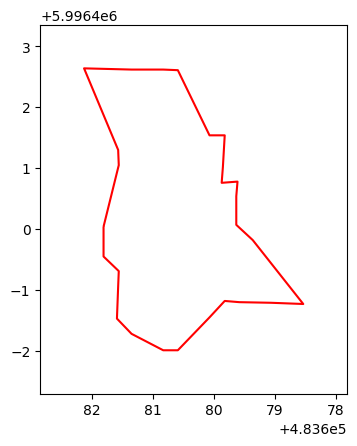

XX1442t_223 : CompositeVV_2023_LeavesOn_XX1442t.tif


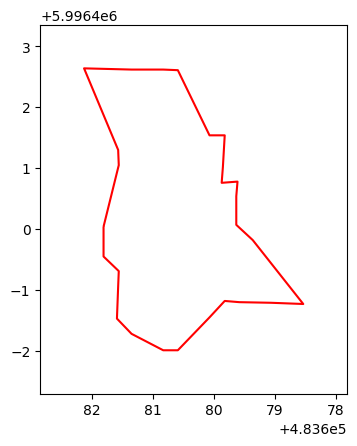

XX1442t_223 : DpRVIVV_2023_LeavesOff_XX1442t.tif


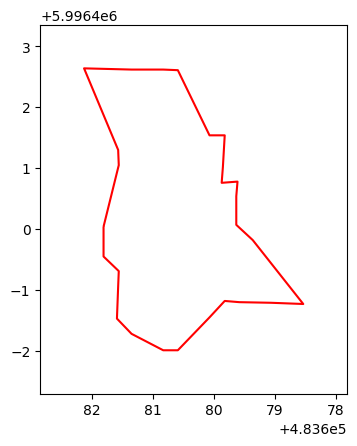

XX1442t_223 : DpRVIVV_2023_LeavesOn_XX1442t.tif


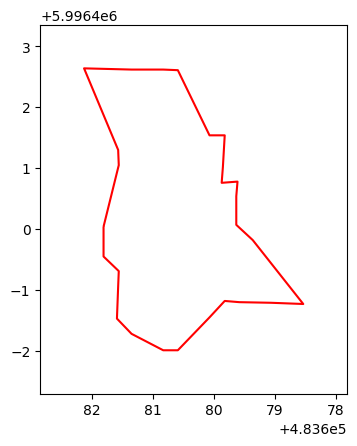

XX1442t_223 : LANDFORM_XX1442t.tif


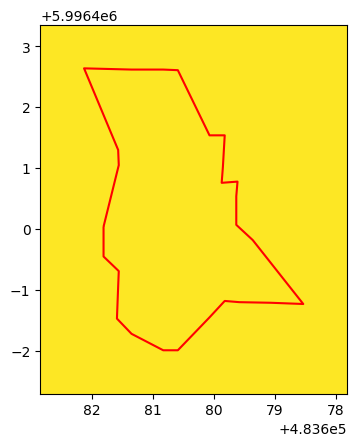

XX1442t_223 : NDPolI_2023_LeavesOff_XX1442t.tif


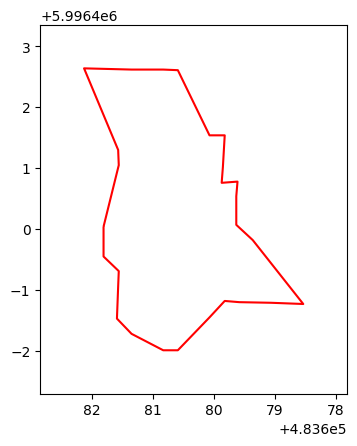

XX1442t_223 : NDPolI_2023_LeavesOn_XX1442t.tif


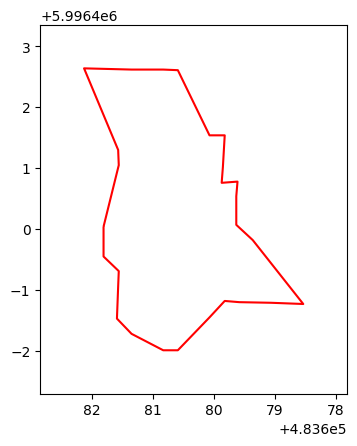

XX1442t_223 : VDDPI_2023_LeavesOff_XX1442t.tif


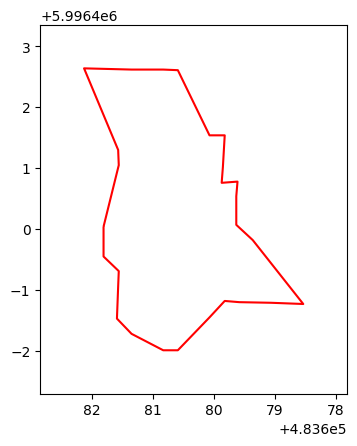

XX1442t_223 : VDDPI_2023_LeavesOn_XX1442t.tif


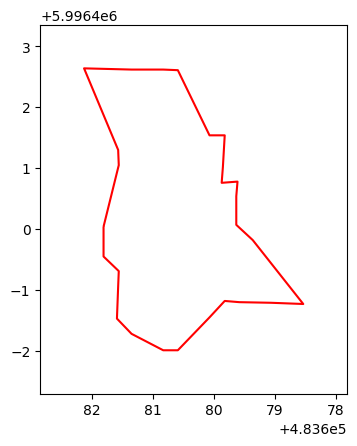

XX1442t_1129 : CompositeVH_2023_LeavesOff_XX1442t.tif


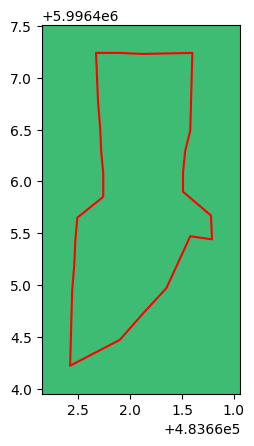

XX1442t_1129 : CompositeVH_2023_LeavesOn_XX1442t.tif


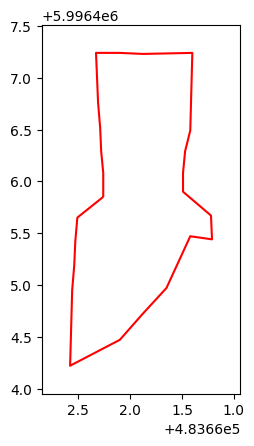

XX1442t_1129 : CompositeVV_2023_LeavesOff_XX1442t.tif


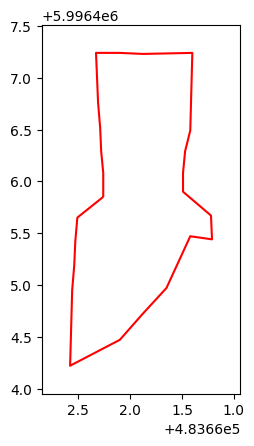

XX1442t_1129 : CompositeVV_2023_LeavesOn_XX1442t.tif


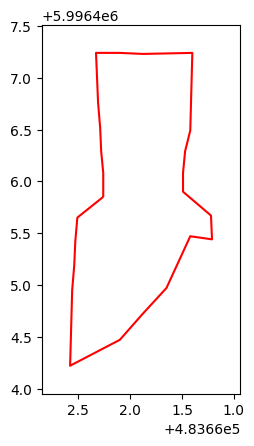

XX1442t_1129 : DpRVIVV_2023_LeavesOff_XX1442t.tif


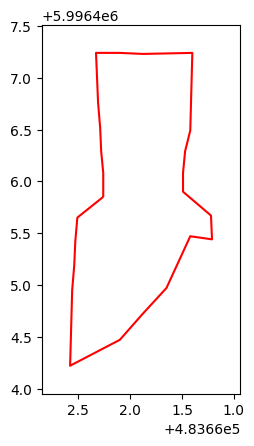

XX1442t_1129 : DpRVIVV_2023_LeavesOn_XX1442t.tif


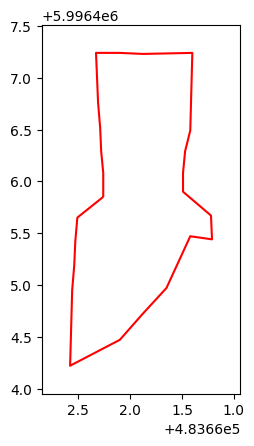

XX1442t_1129 : LANDFORM_XX1442t.tif


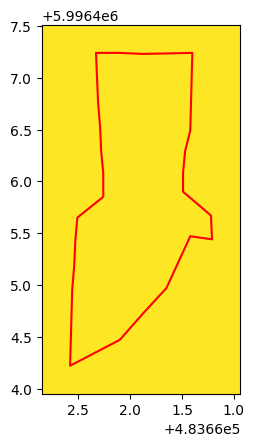

XX1442t_1129 : NDPolI_2023_LeavesOff_XX1442t.tif


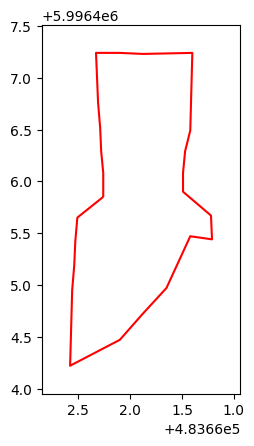

XX1442t_1129 : NDPolI_2023_LeavesOn_XX1442t.tif


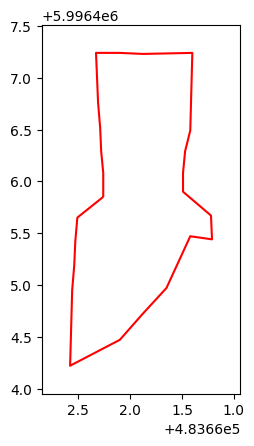

XX1442t_1129 : VDDPI_2023_LeavesOff_XX1442t.tif


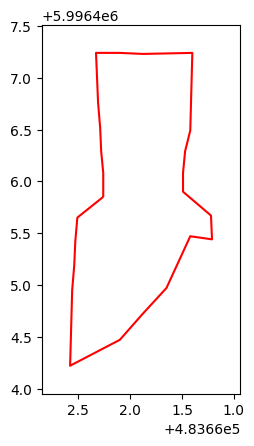

XX1442t_1129 : VDDPI_2023_LeavesOn_XX1442t.tif


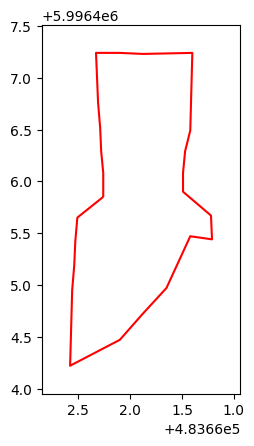

In [121]:
error_shapes_shp = gpd.read_file(os.path.join(SiVi_errors_directory,"error_shapes.shp"))

# Function to plot the shape and TIFF
def plot_shape_with_tif(shape, tif_path):
    # Adjust plot extent slightly for buffer
    shp_bounds = shape.bounds
    buffer = 0.2 * (shp_bounds[2] - shp_bounds[0])  # Adjust buffer amount as needed
    west, south, east, north = shp_bounds[0] - buffer, shp_bounds[1] - buffer, shp_bounds[2] + buffer, shp_bounds[3] + buffer
    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots()
        ax.set_ylim(south,north) # Set Y Limit
        ax.set_xlim(east,west) # Set X Limit
        show(src, ax=ax)
        gpd.GeoSeries(shape).boundary.plot(ax=ax, facecolor='none', edgecolor='red') # Display SHP
        plt.show()
        

# Iterate through each row in the GeoDataFrame
for idx, row in error_shapes_shp.iterrows():
    if row['UNIQUE_ID'] in output_withoutNEGvalue:
        stand_id = row['STANDID']
        for item in os.listdir(SiVi_errors_directory):
            if item.endswith(f"{stand_id}.tif"):
                tif_path = os.path.join(SiVi_errors_directory, item)

                if os.path.exists(tif_path):
                    print(fr"{row['UNIQUE_ID']} : {item}")
                    plot_shape_with_tif(row['geometry'], tif_path)
                else:
                    print(f"No matching TIFF file for STANDID: {stand_id}")